In [1]:
import os
os.chdir("../")
with open('run/settings.py', 'r') as file:
    exec(file.read())

Random seed set to 333
using device:  cpu


In [2]:
# (customize) configs
overwrite = False
model_name = 'air_quality' 

update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'city_str',
    y_levels = ['This is air quality in Beijing.', 'This is air quality in London.'],
    y_pred_levels = ['This is air quality in Beijing.', 'This is air quality in London.'],
    # txt2ts
    txt2ts_y_cols = ['city_str', 'season_str', 'year_str'],# 
    
    
    # Data settings
    seq_length = 168,
    text_col = 'ts_description', #'ts_description',
    custom_target_cols = [ 'city_str', 'season_str', 'year_str', 'label'], # 
    
    
    # Model settings
    model_name = model_name,
    variational = False,
    
    # Train settings
    init_lr = 1e-4,
    num_saves = 2
)
config_dict = get_config_dict()

In [3]:
# change data preparation for a given experiment
with open('run/prepare_datasets/air_quality.py', 'r') as file:
    exec(file.read())
# prepare model inputs
with open('run/inputs.py', 'r') as file:
    exec(file.read())

After downsampling:
city_str
This is air quality in Beijing.    2117
This is air quality in London.      830
Name: count, dtype: int64
After downsampling:
city_str
This is air quality in Beijing.    529
This is air quality in London.     208
Name: count, dtype: int64


final distribution of text prediction
text
This is air quality in Beijing. The season is winter. It is measured in 2017.    329
This is air quality in Beijing. The season is fall. It is measured in 2017.      285
This is air quality in Beijing. The season is spring. It is measured in 2017.    233
This is air quality in Beijing. The season is summer. It is measured in 2017.    222
This is air quality in London. The season is spring. It is measured in 2017.     201
This is air quality in Beijing. The season is winter. It is measured in 2018.    191
This is air quality in London. The season is winter. It is measured in 2017.     180
This is air quality in London. The season is fall. It is measured in 2017.       167
This is

In [4]:
with open('run/model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                                                      Param #
VITAL                                                                       --
├─TSVAEEncoder: 1-1                                                         --
│    └─LocalNorm: 2-1                                                       --
│    └─MultiCNNEncoder: 2-2                                                 768
│    │    └─ModuleList: 3-1                                                 4,136,992
│    │    └─MultiheadAttention: 3-2                                         2,362,368
│    │    └─LayerNorm: 3-3                                                  1,536
│    └─Linear: 2-3                                                          590,592
│    └─Linear: 2-4                                                          590,592
├─TextEncoder: 1-2                                                          --
│    └─TextEncoderMultiCNN: 2-5                                             768
│    │    └─Module

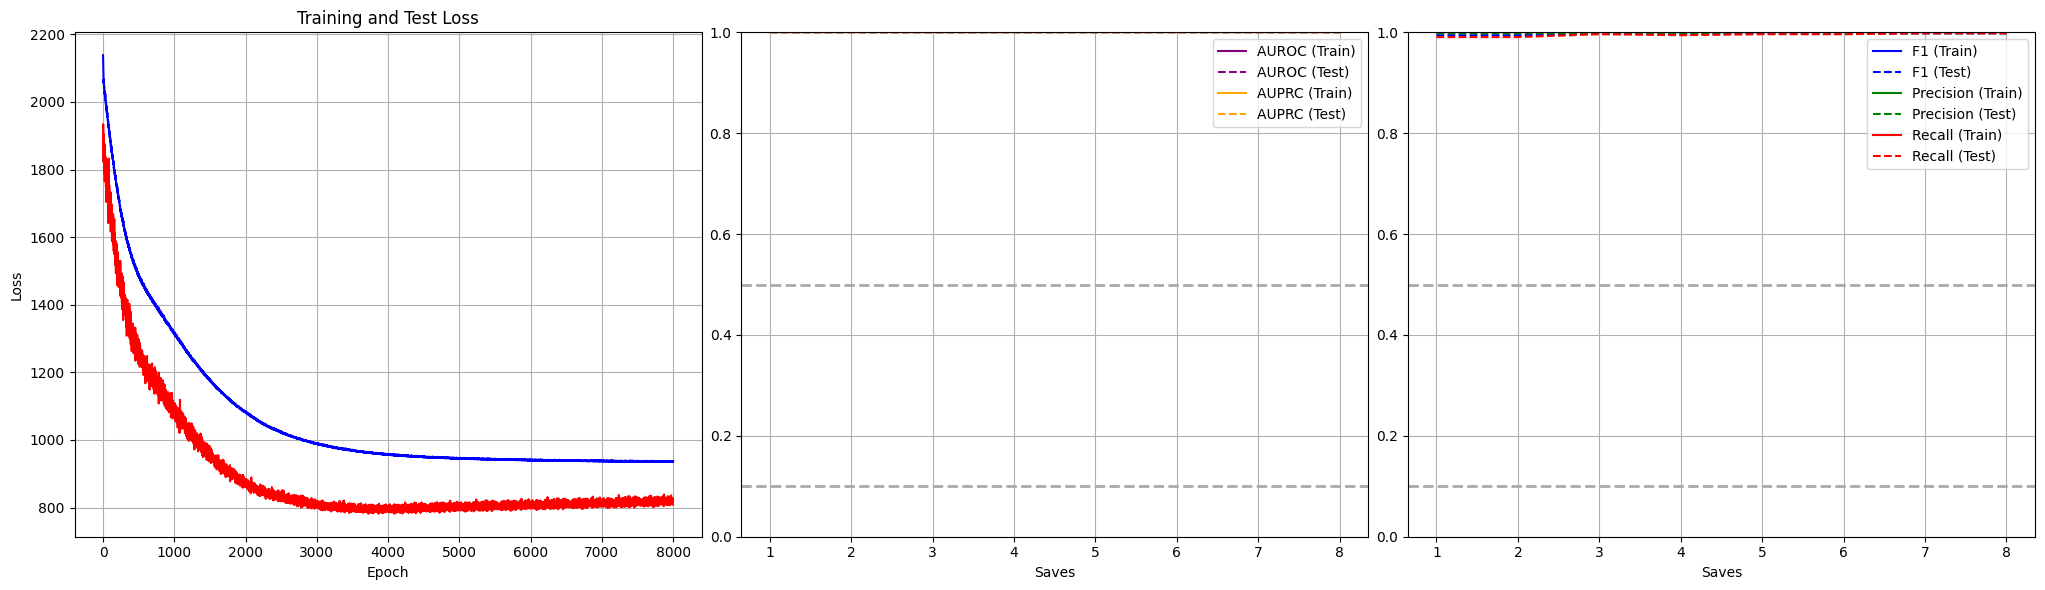

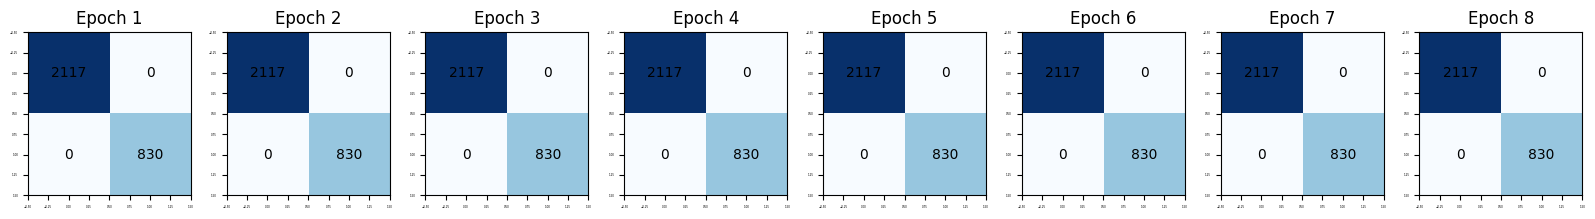

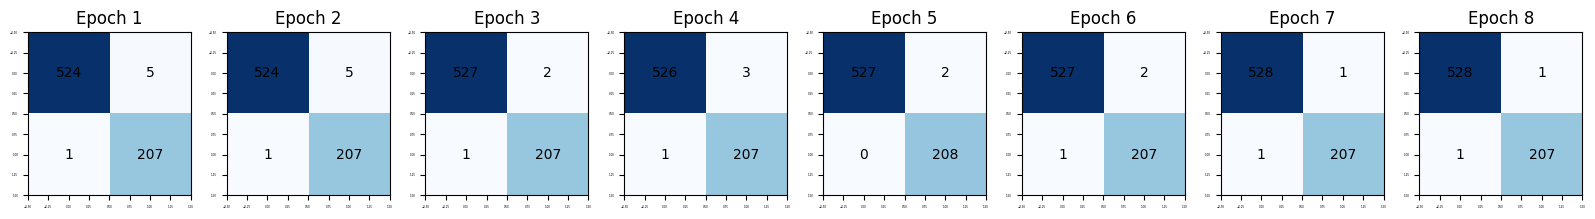

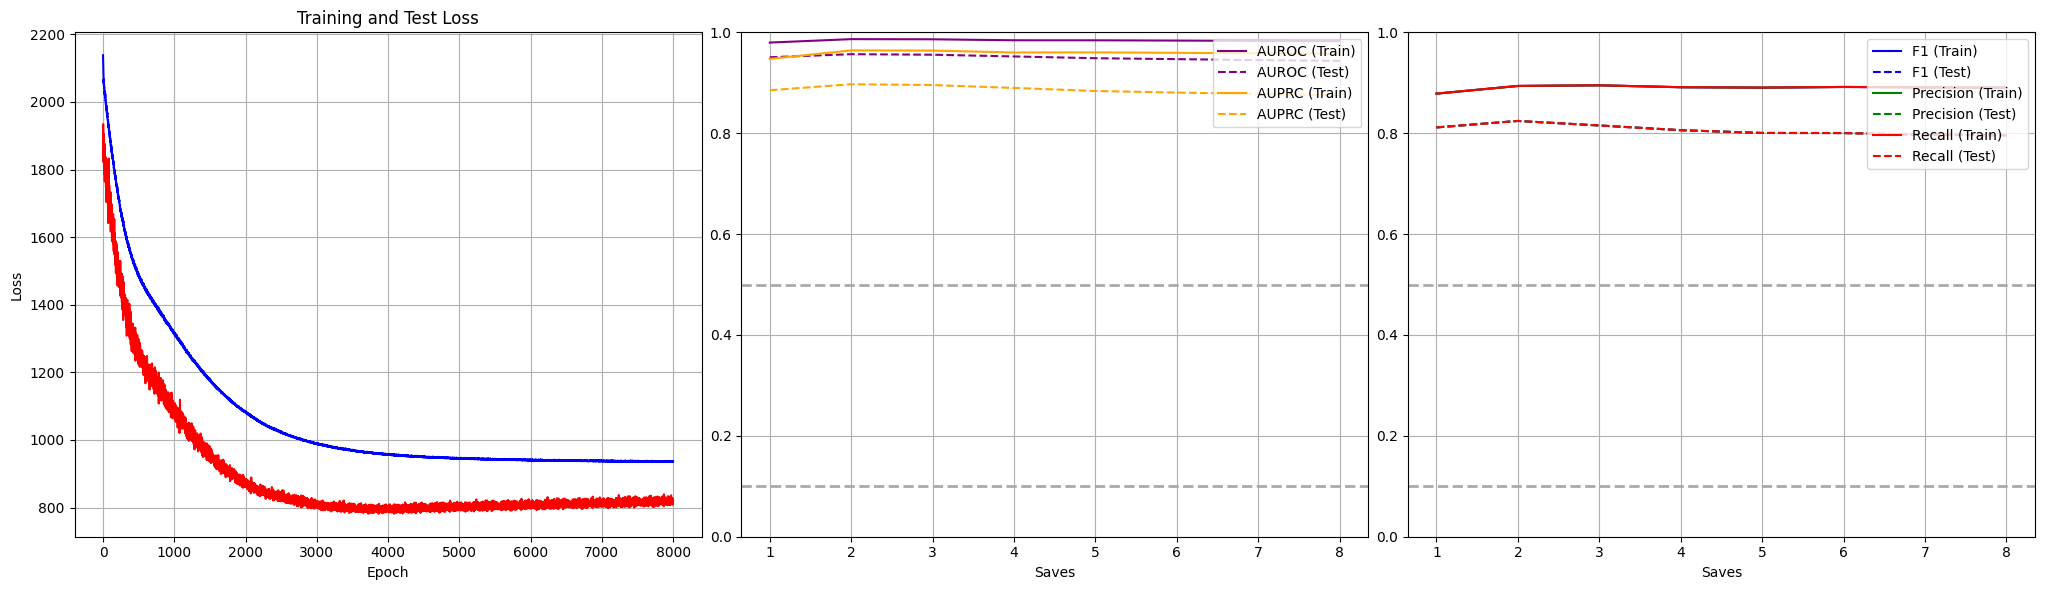

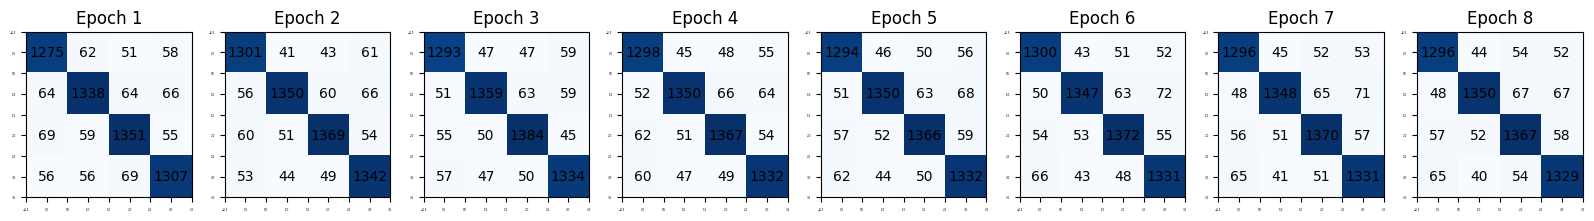

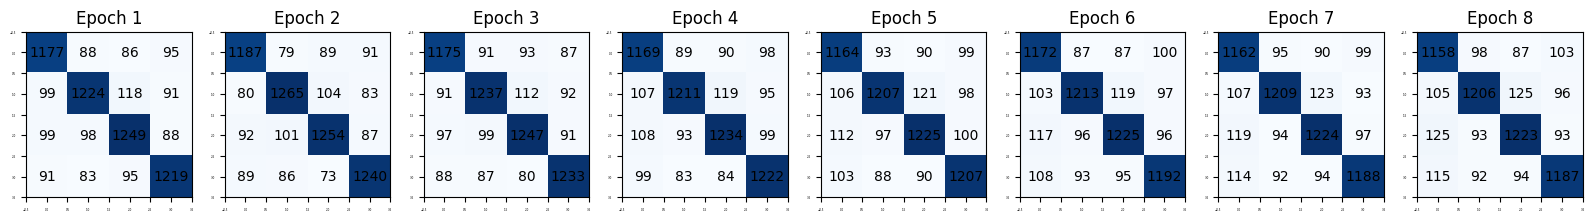

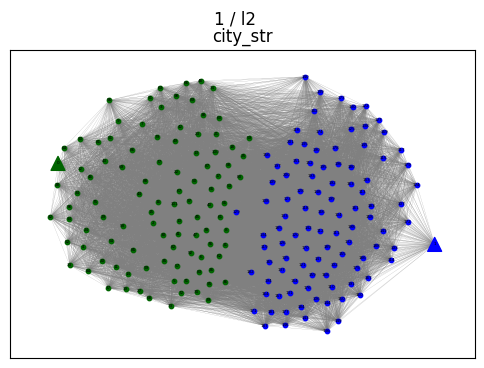

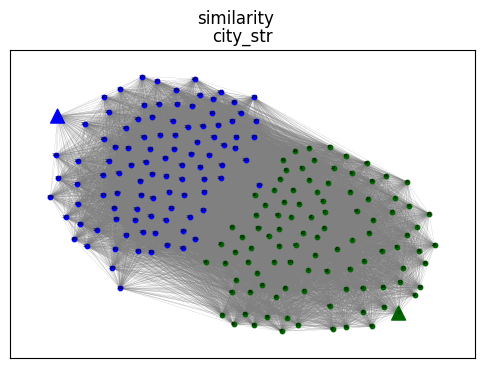

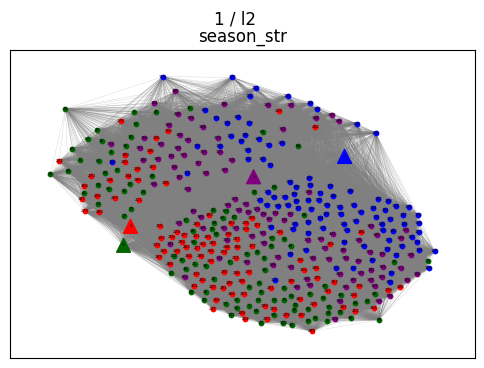

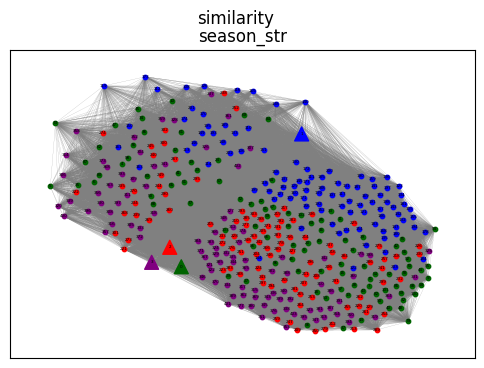

Error plot network embedding for year_str


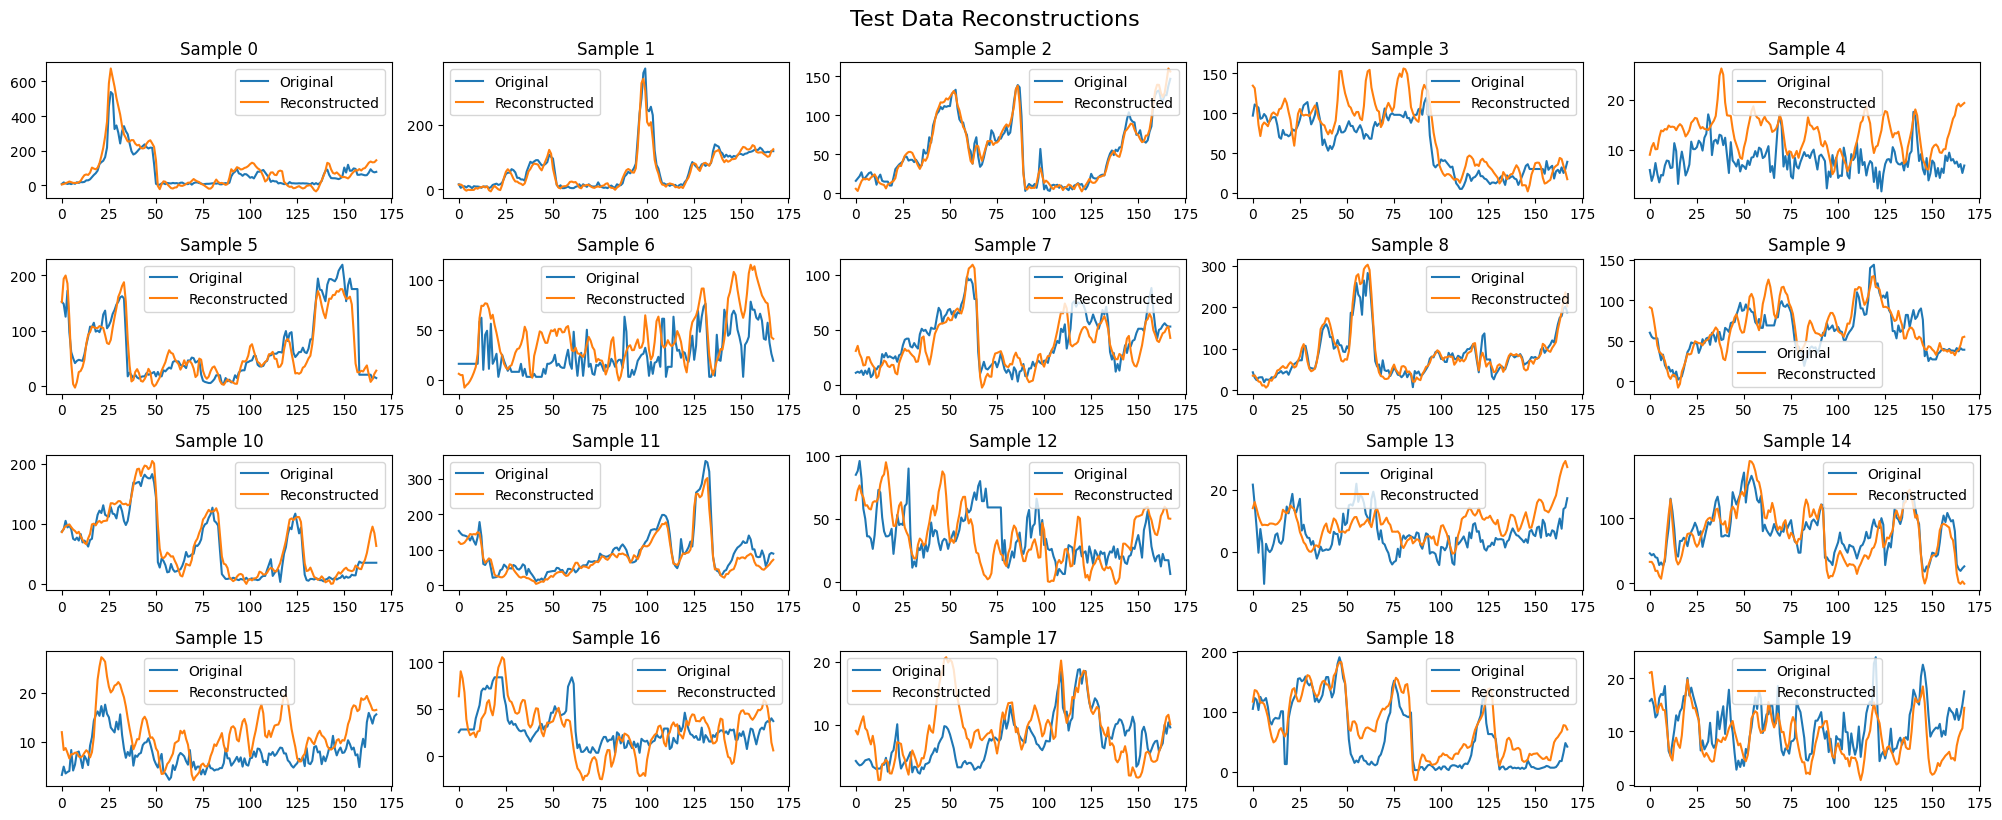

In [5]:
# overwrite = False
with open('run/train.py', 'r') as file:
    exec(file.read())


# Generation

1    This is air quality in Beijing.
Name: city_str, dtype: object


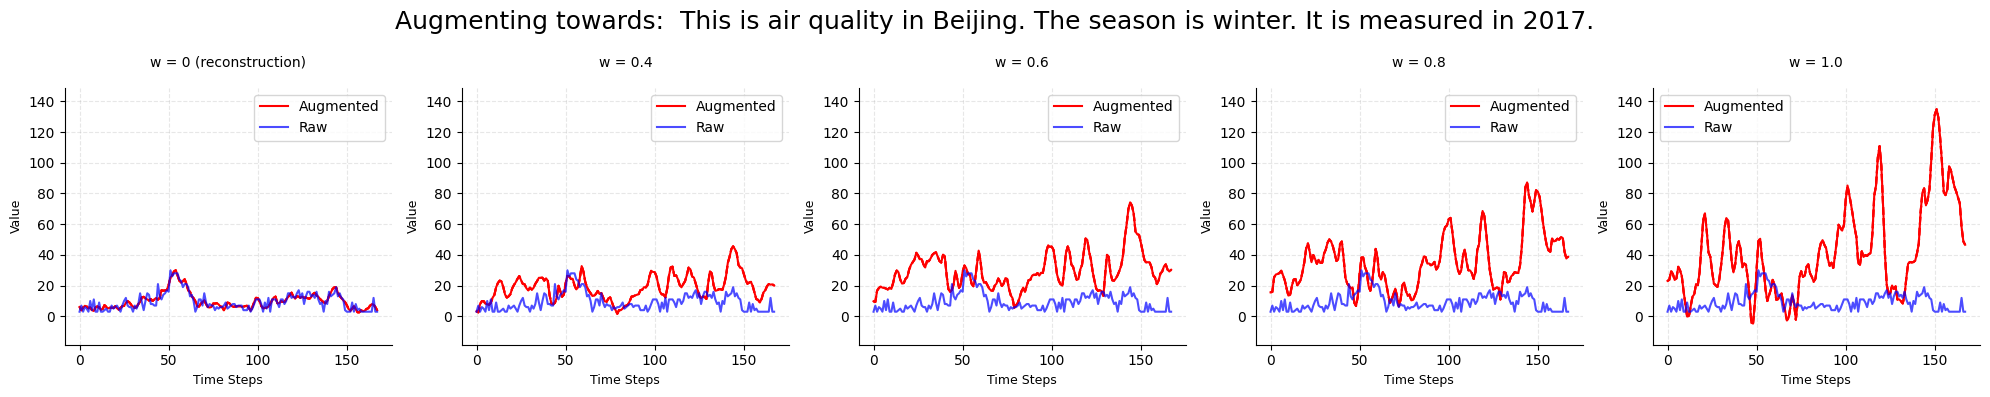

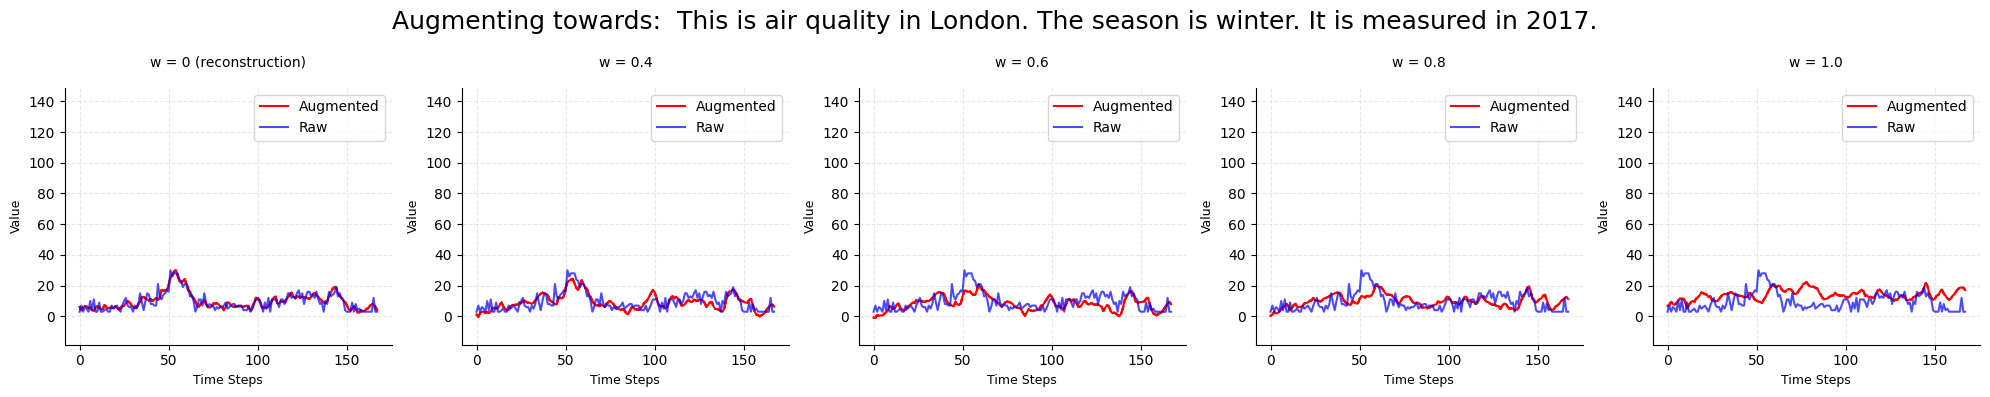

1    This is air quality in London.
Name: city_str, dtype: object


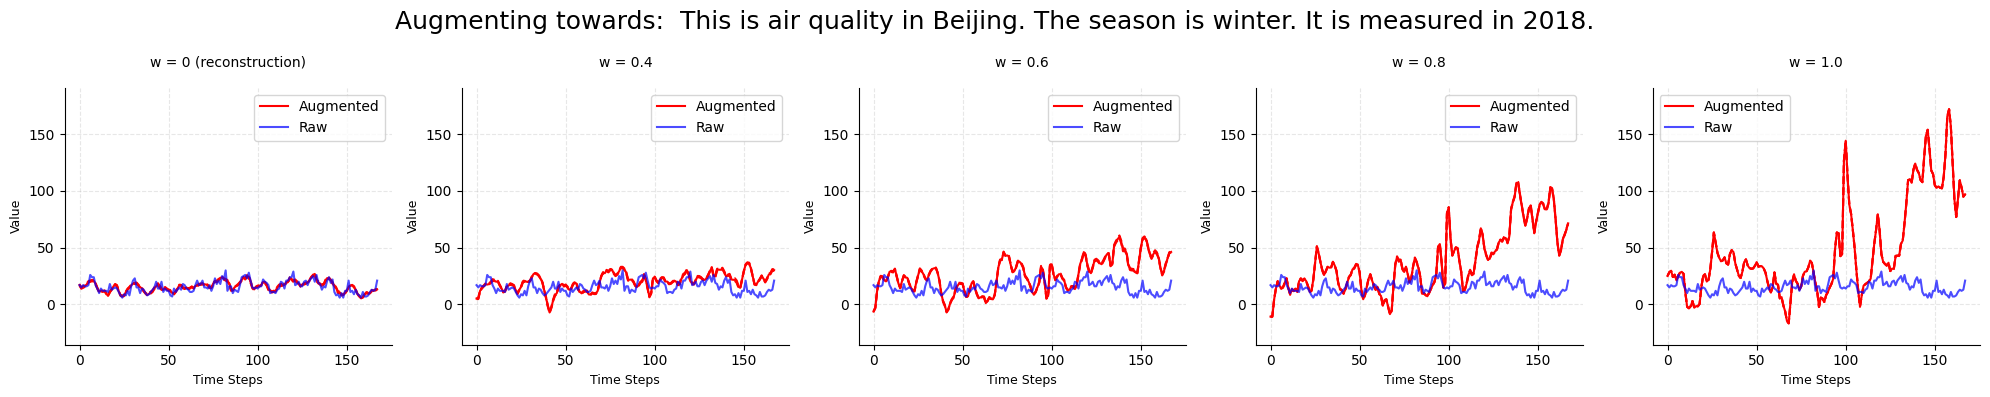

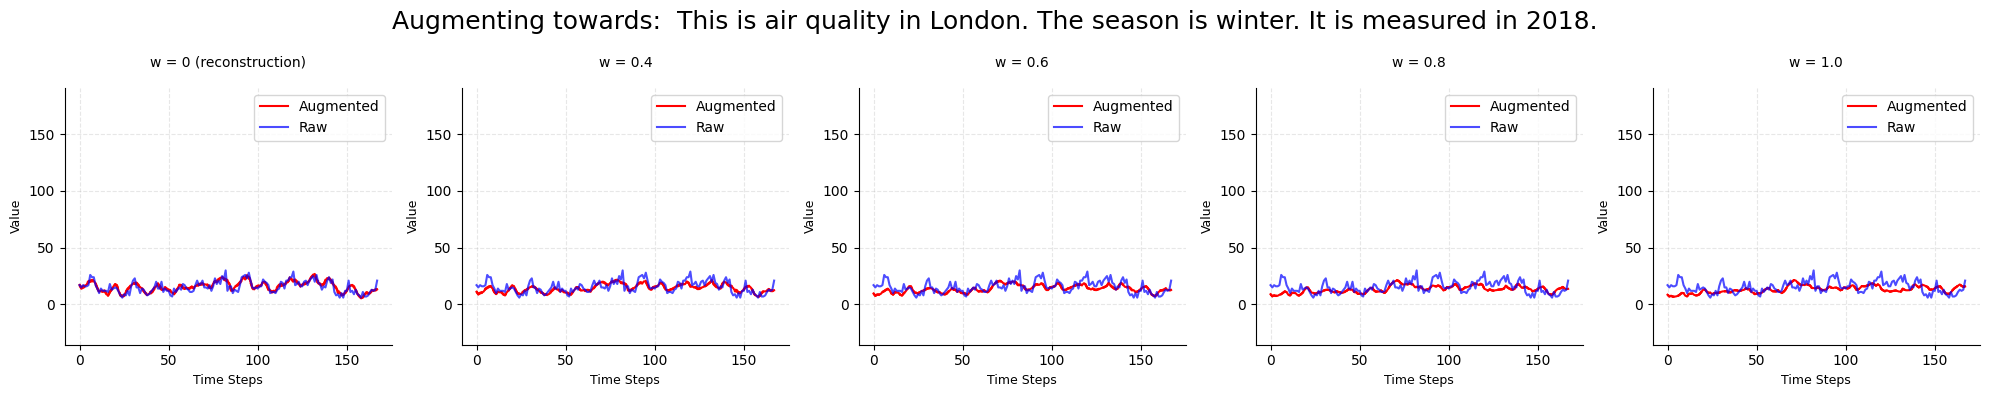

1    The season is summer.
Name: season_str, dtype: object


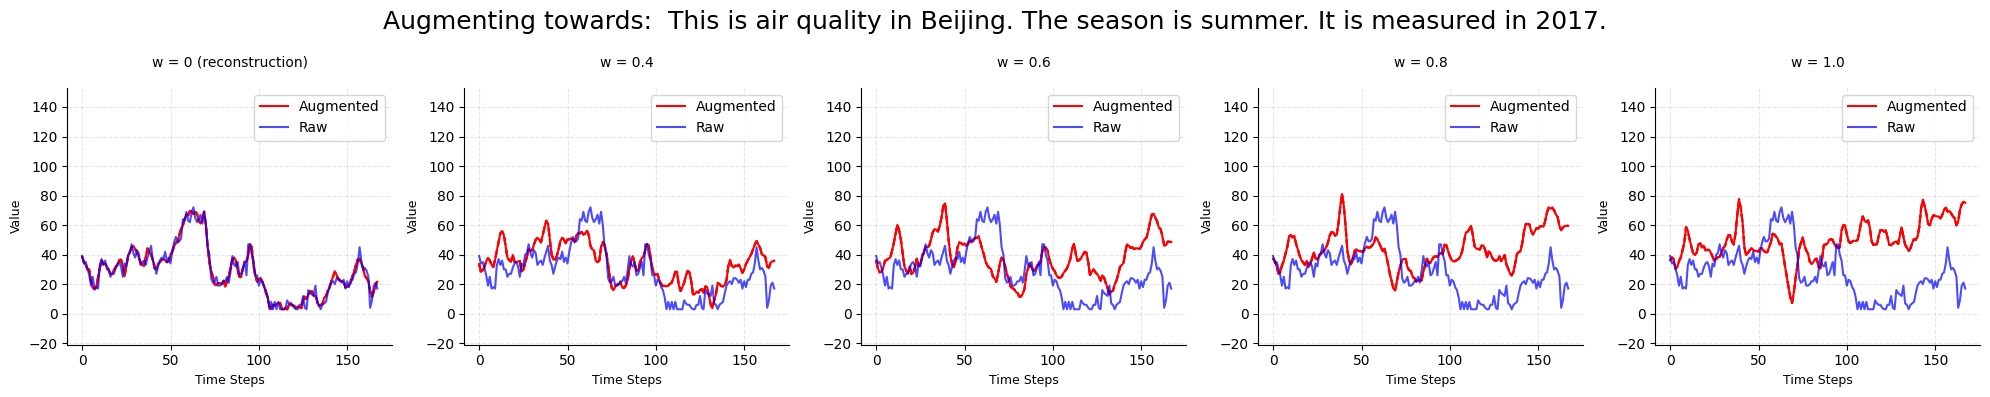

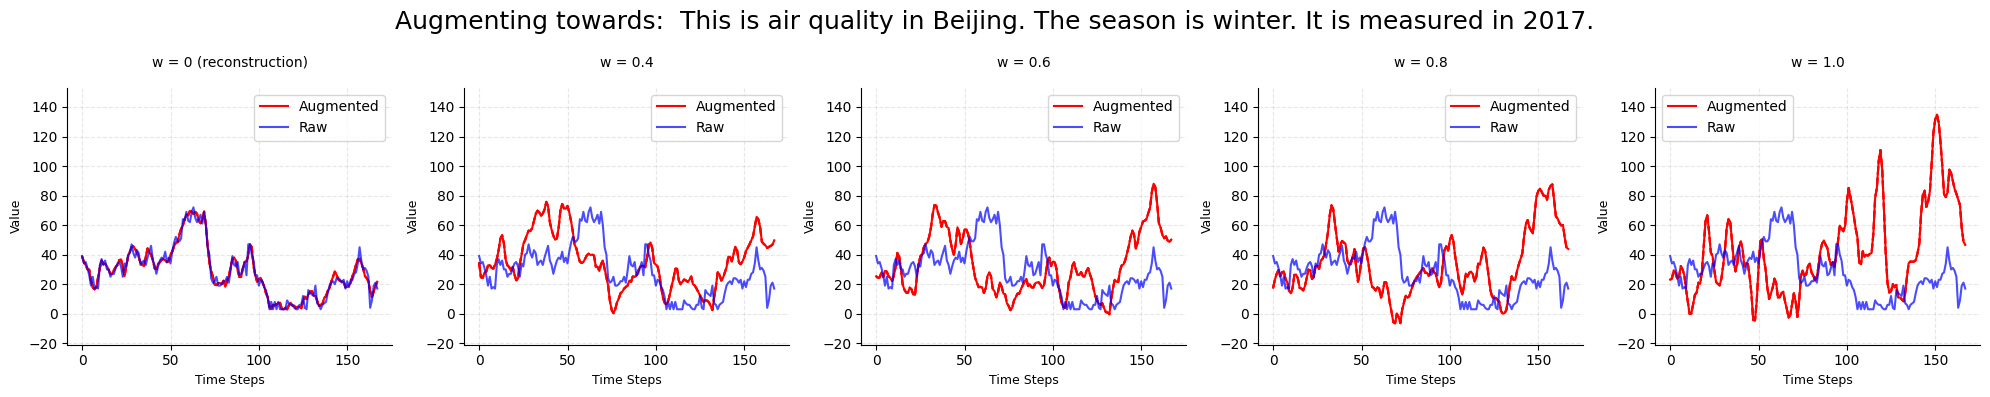

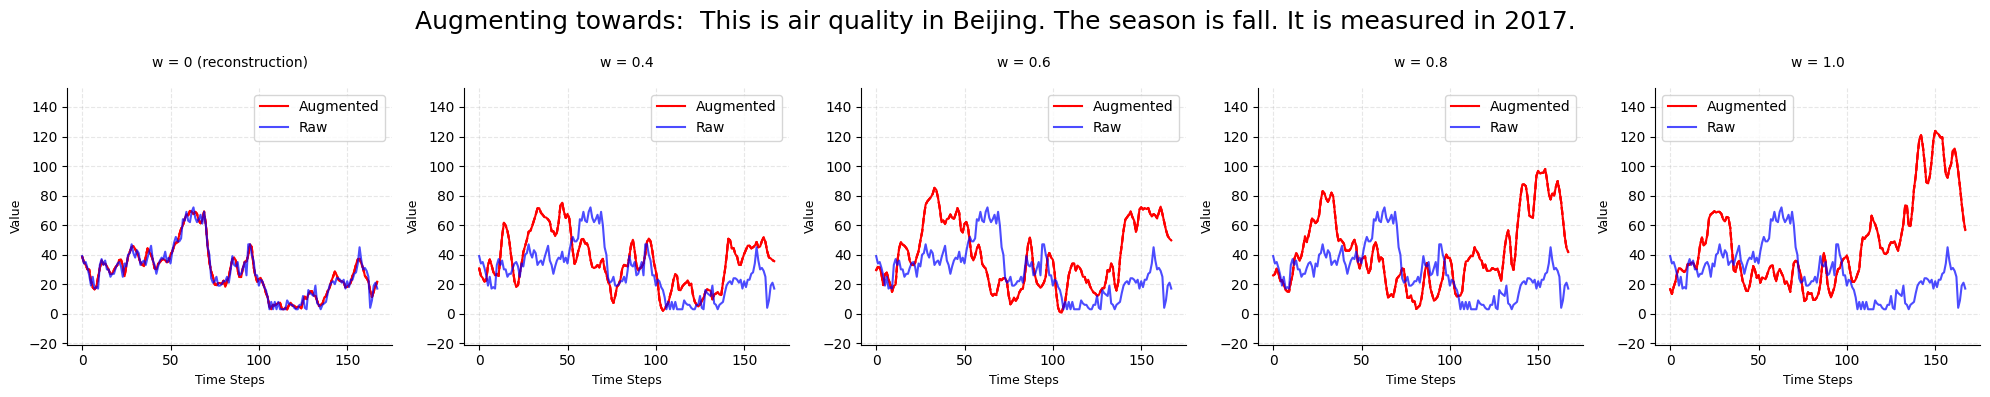

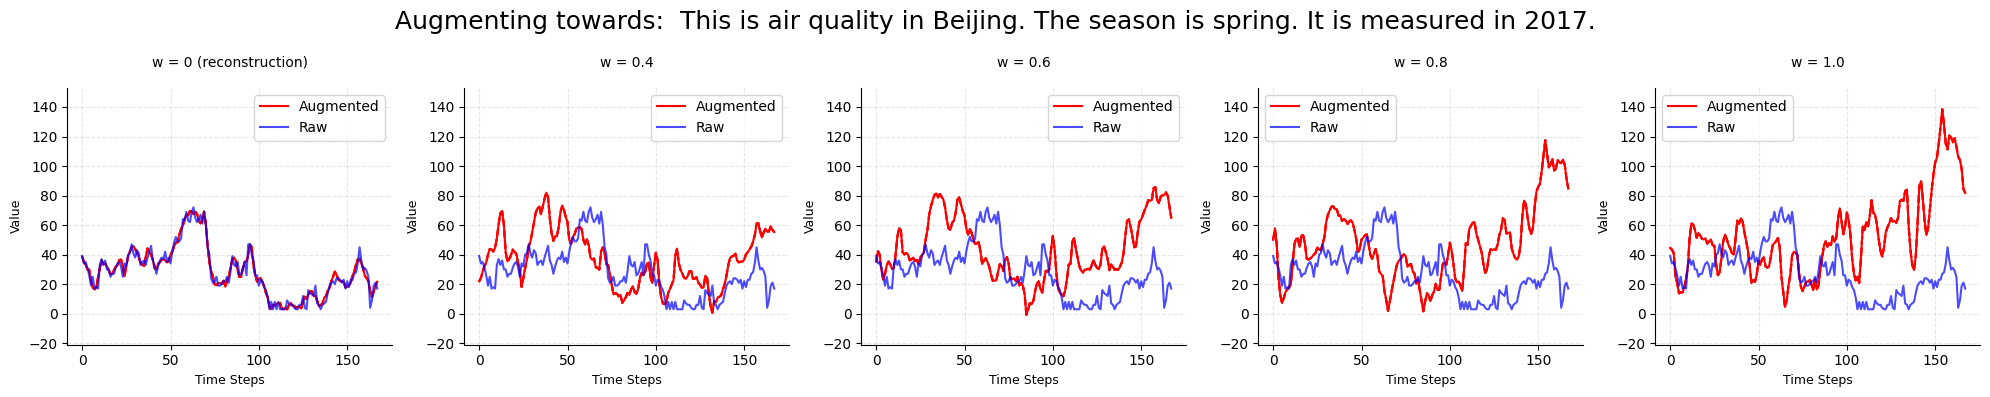

1    The season is winter.
Name: season_str, dtype: object


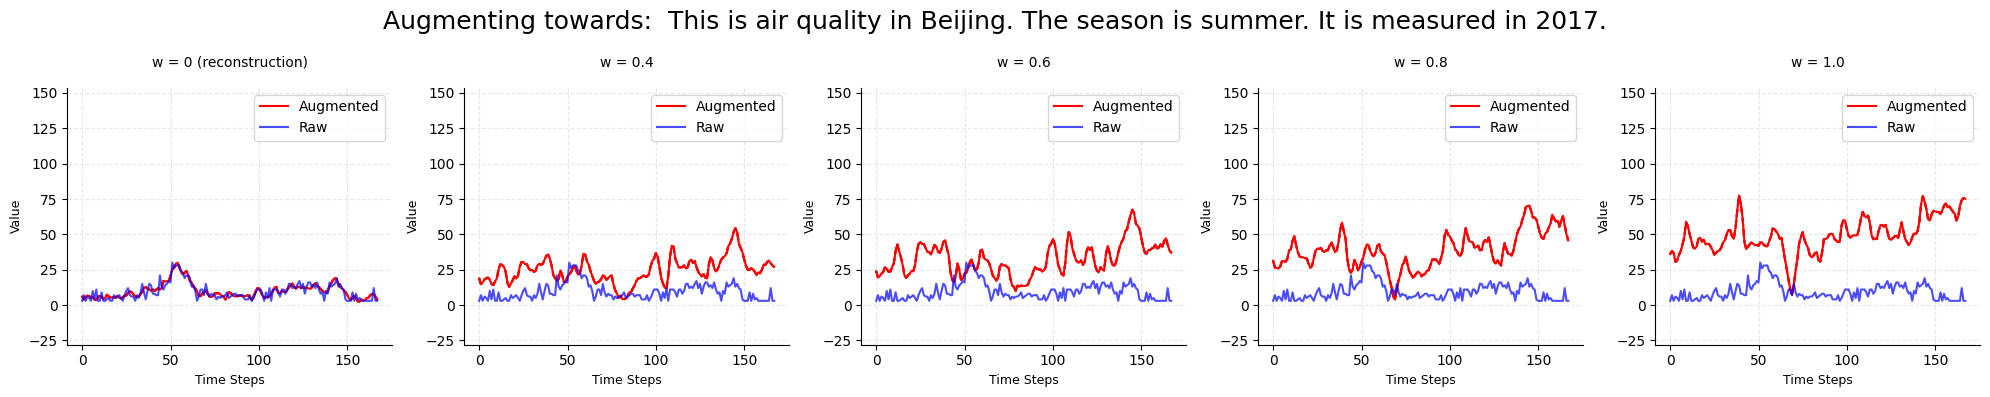

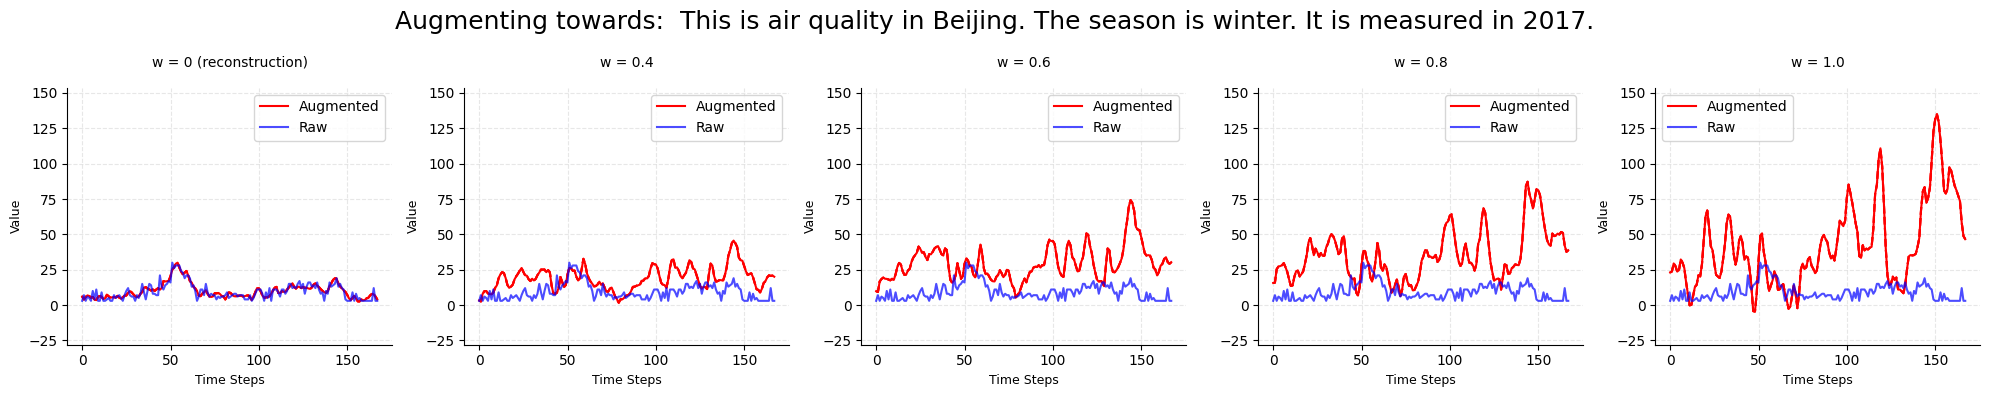

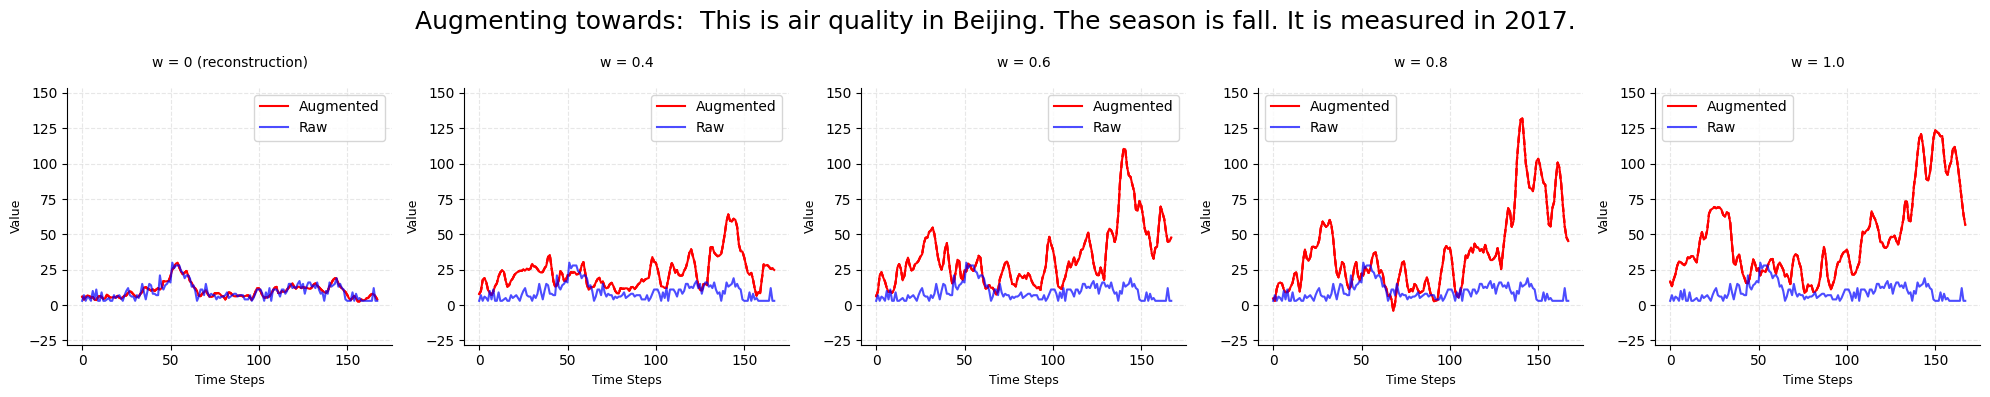

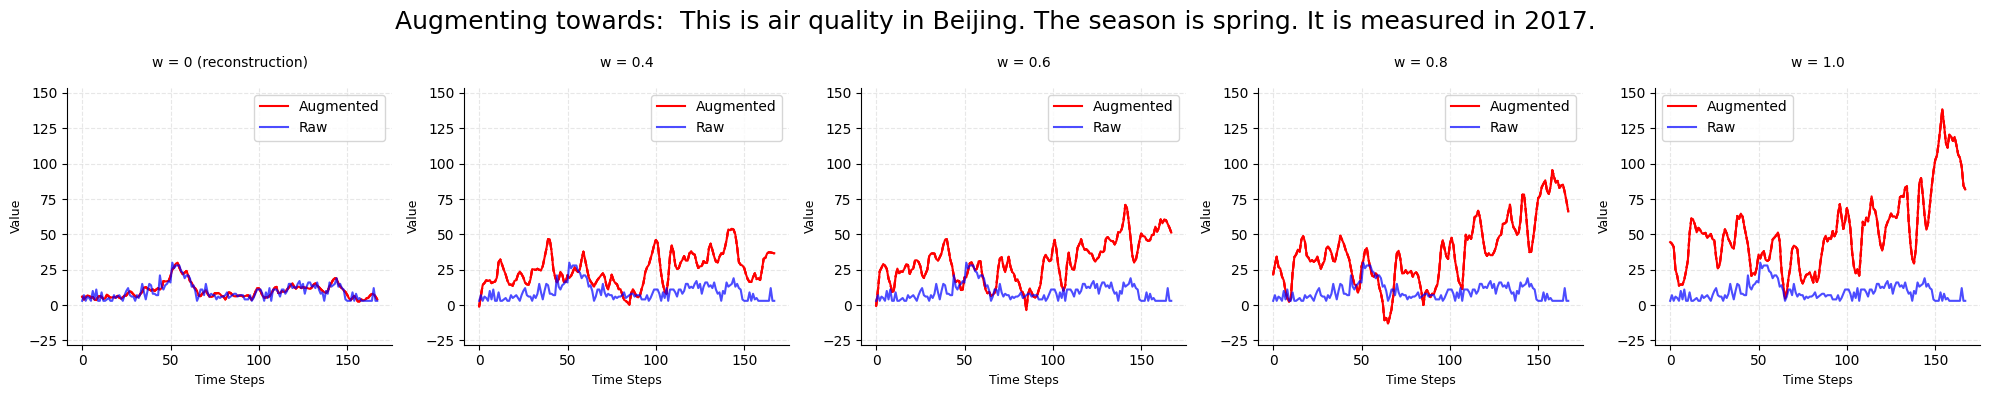

1    The season is fall.
Name: season_str, dtype: object


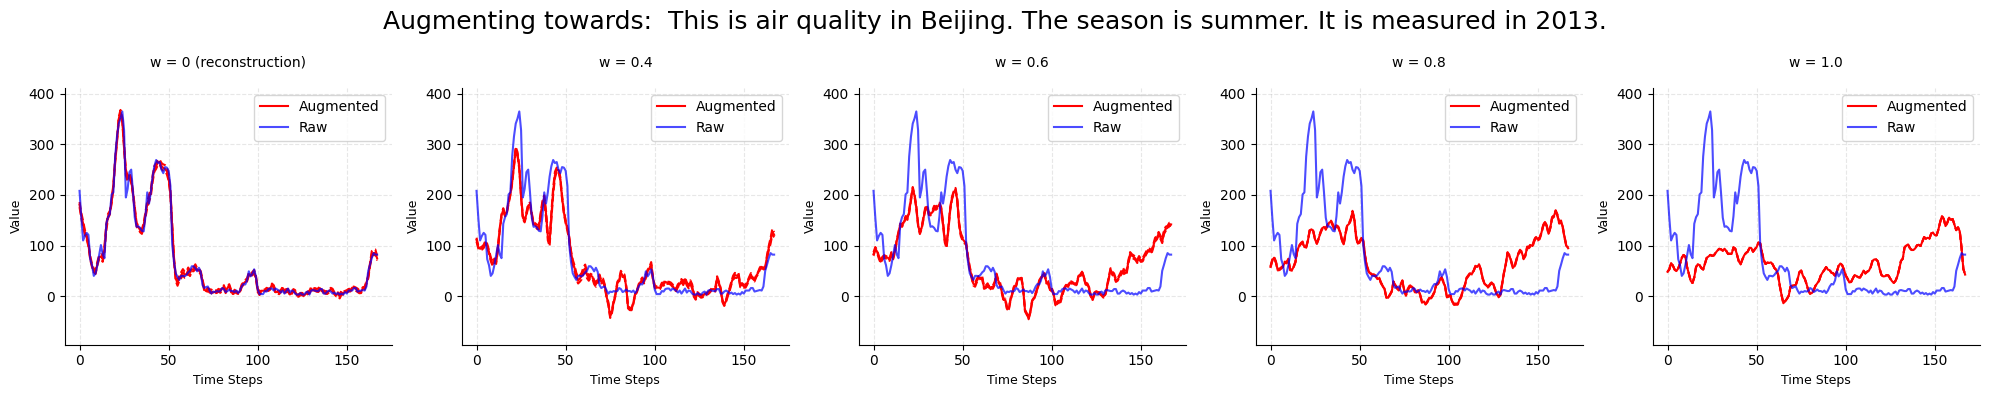

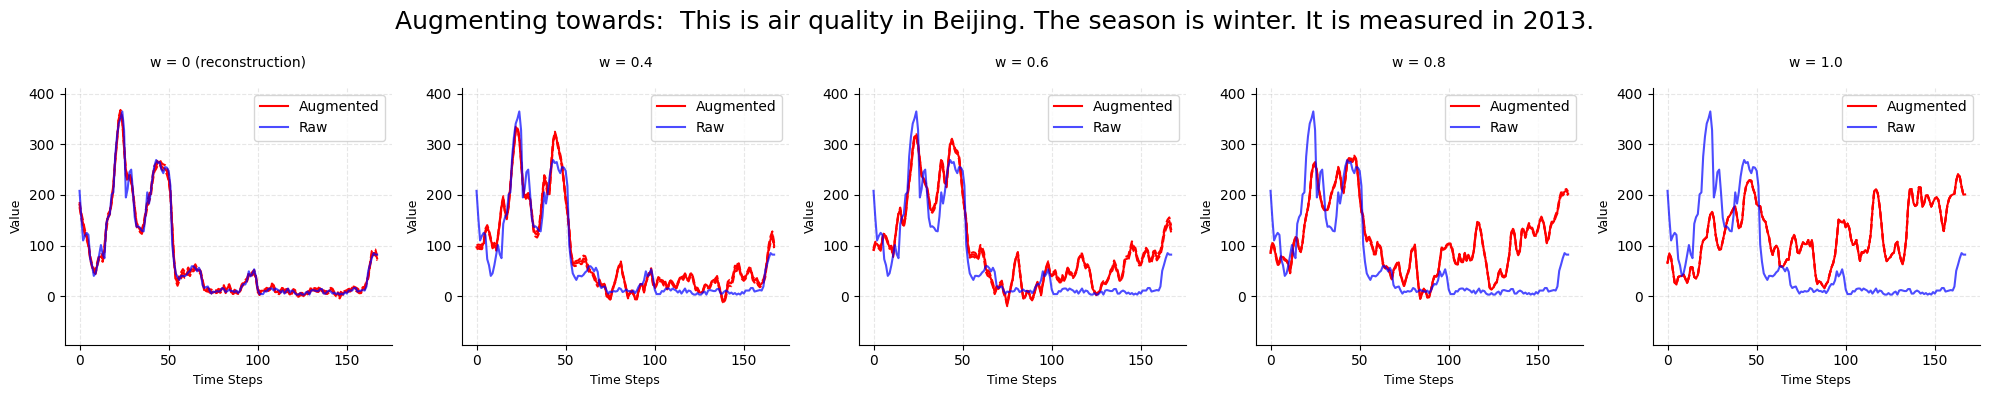

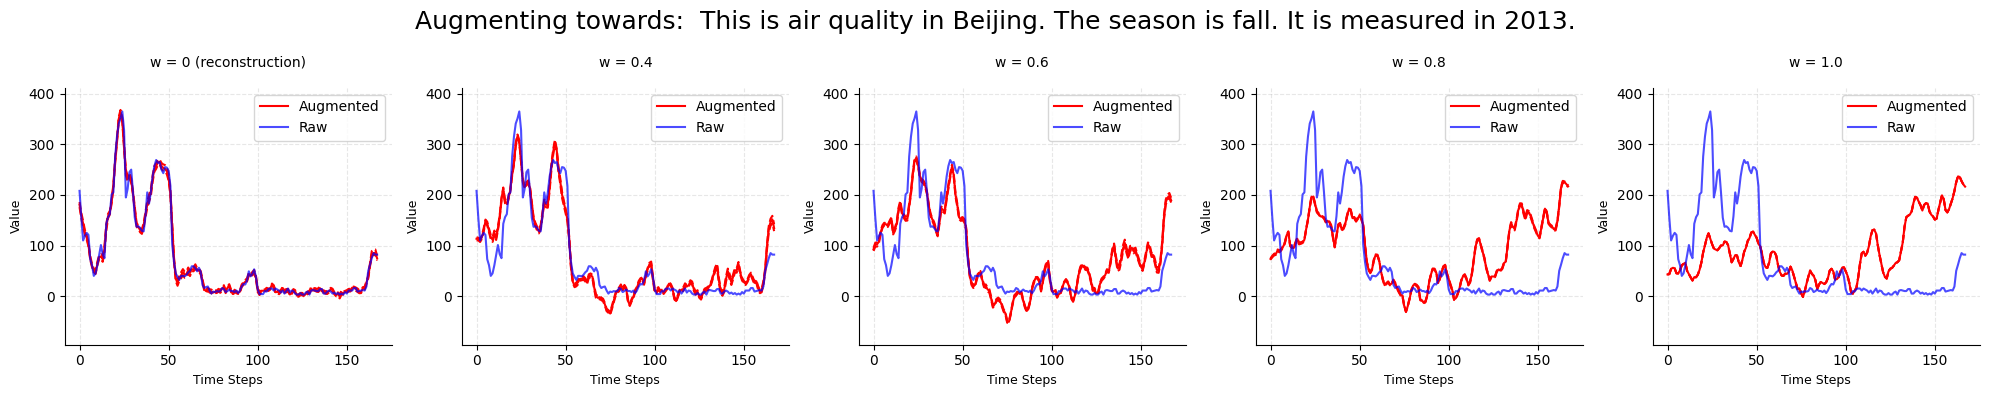

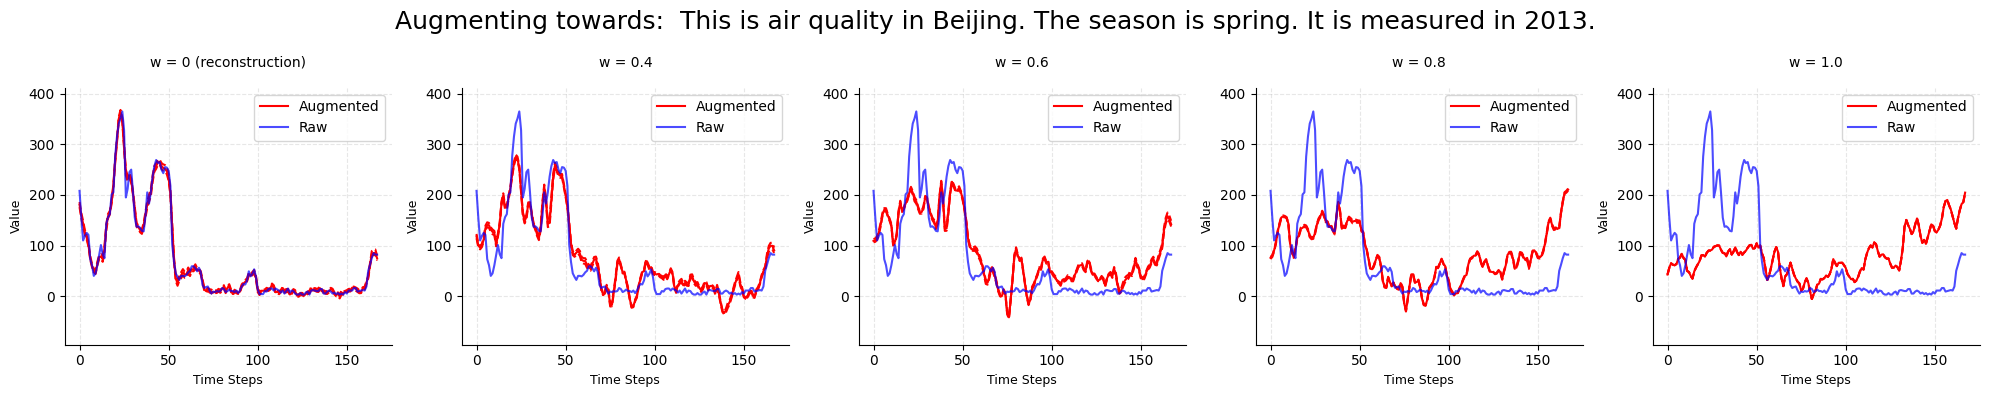

1    The season is spring.
Name: season_str, dtype: object


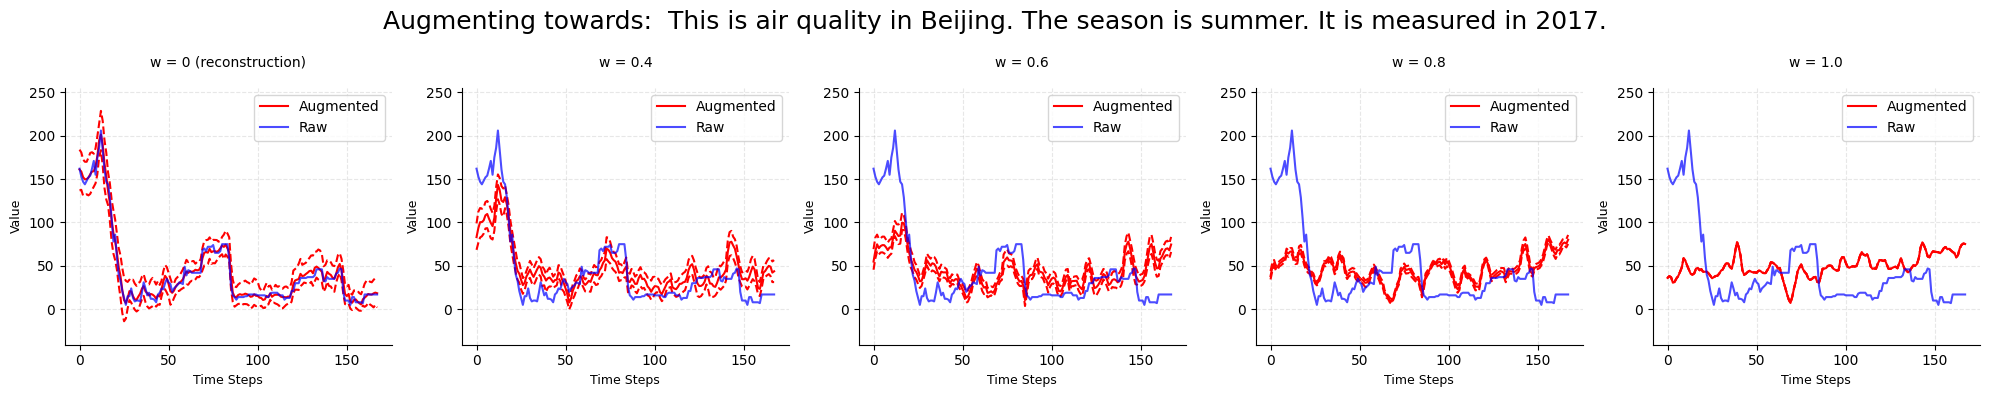

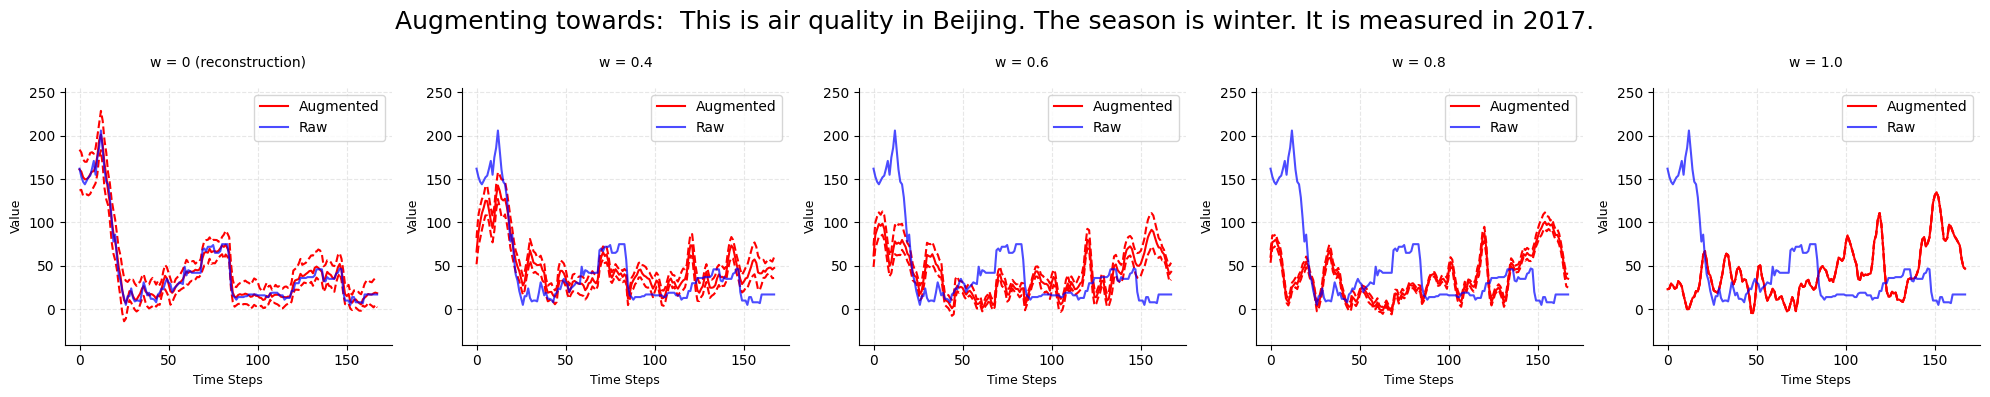

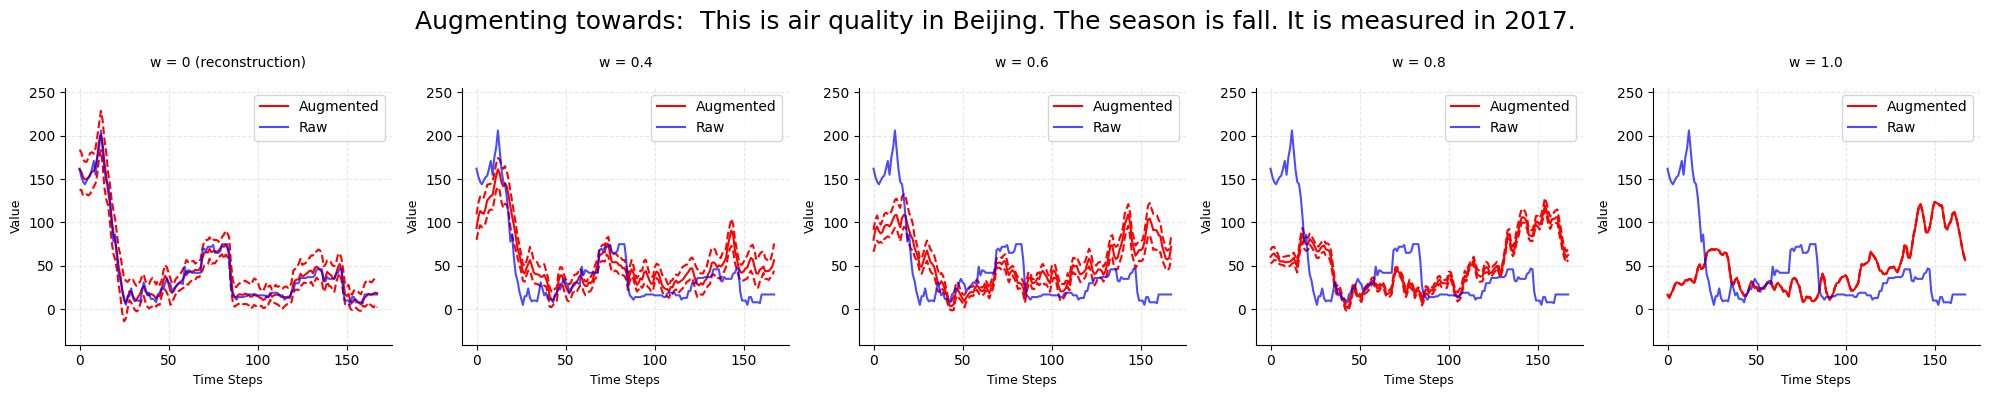

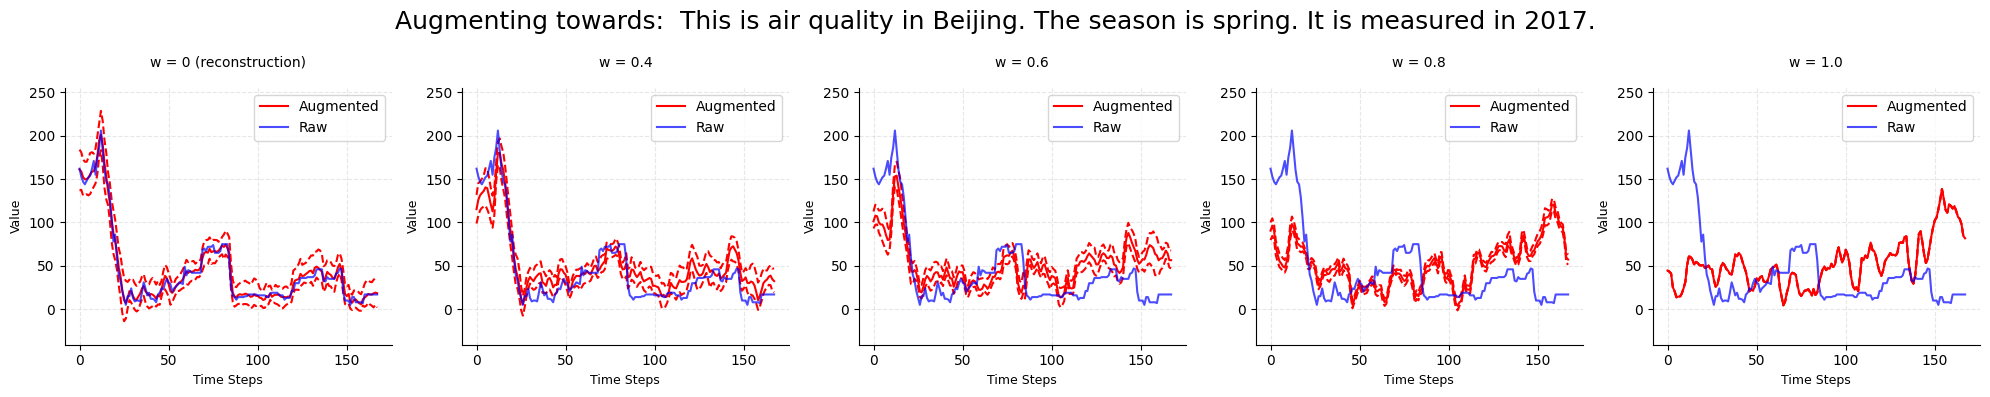

1    It is measured in 2017.
Name: year_str, dtype: object


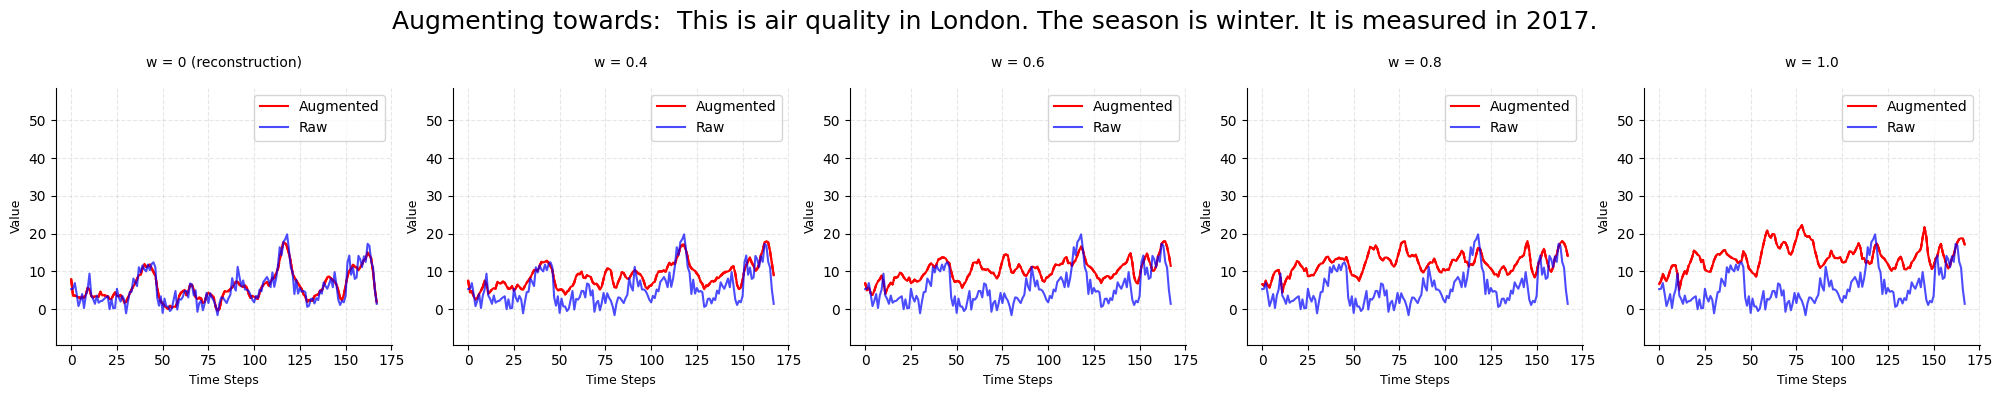

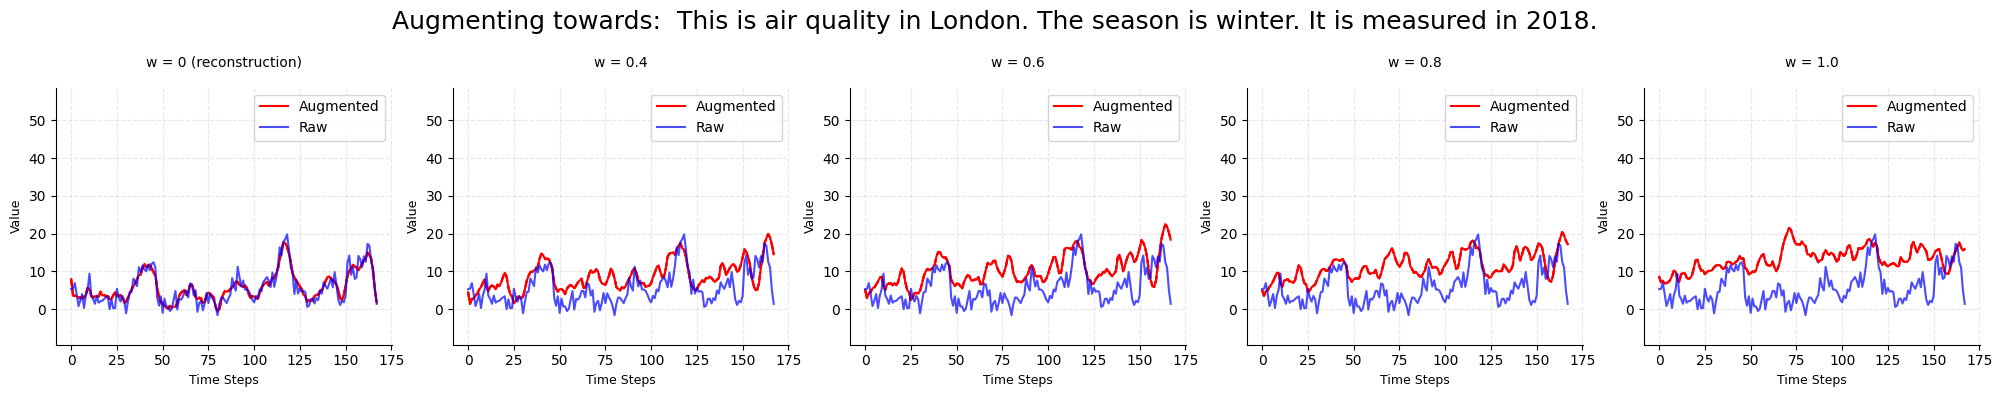

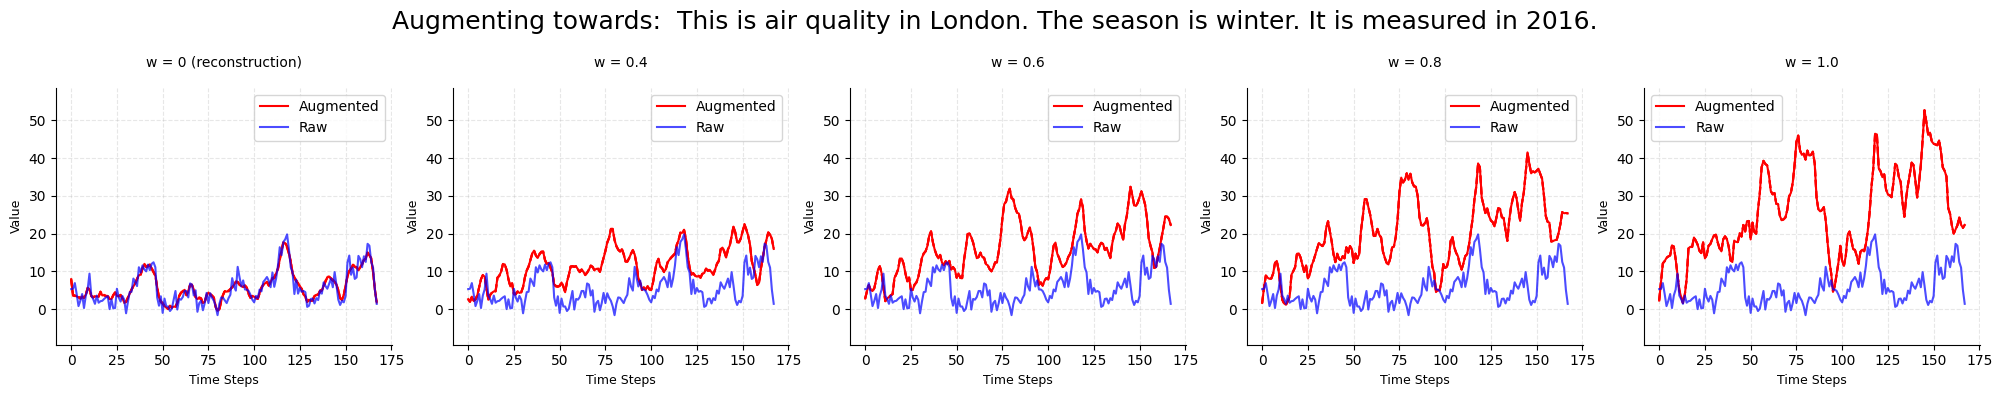

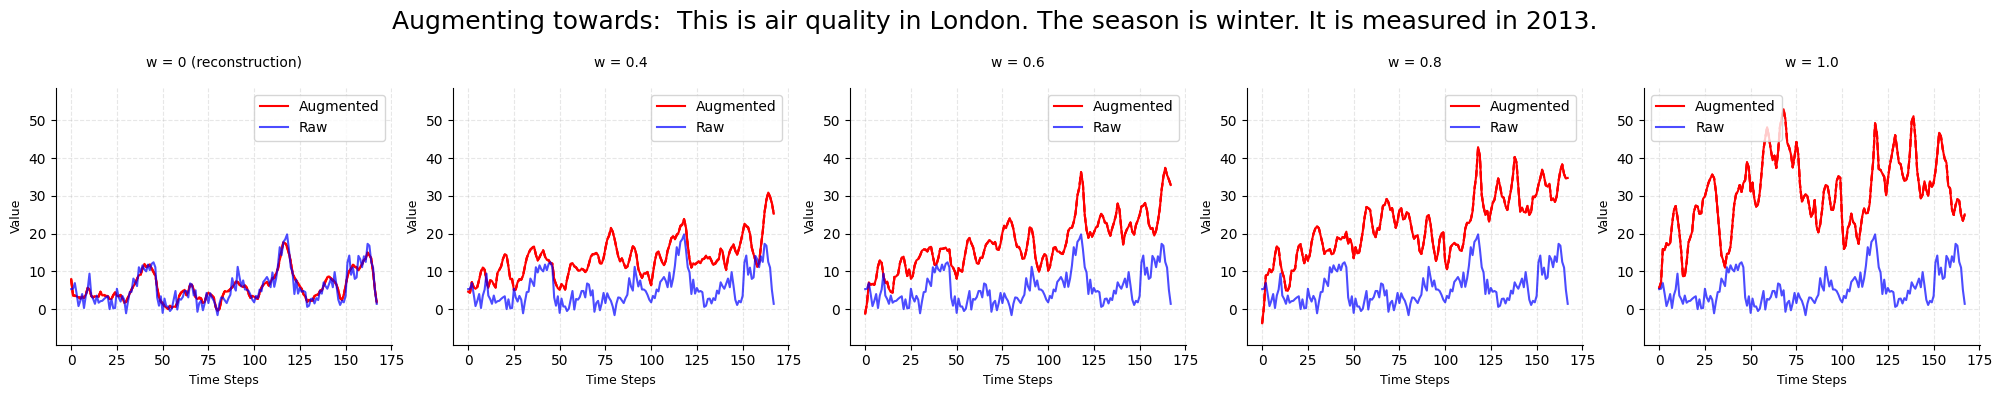

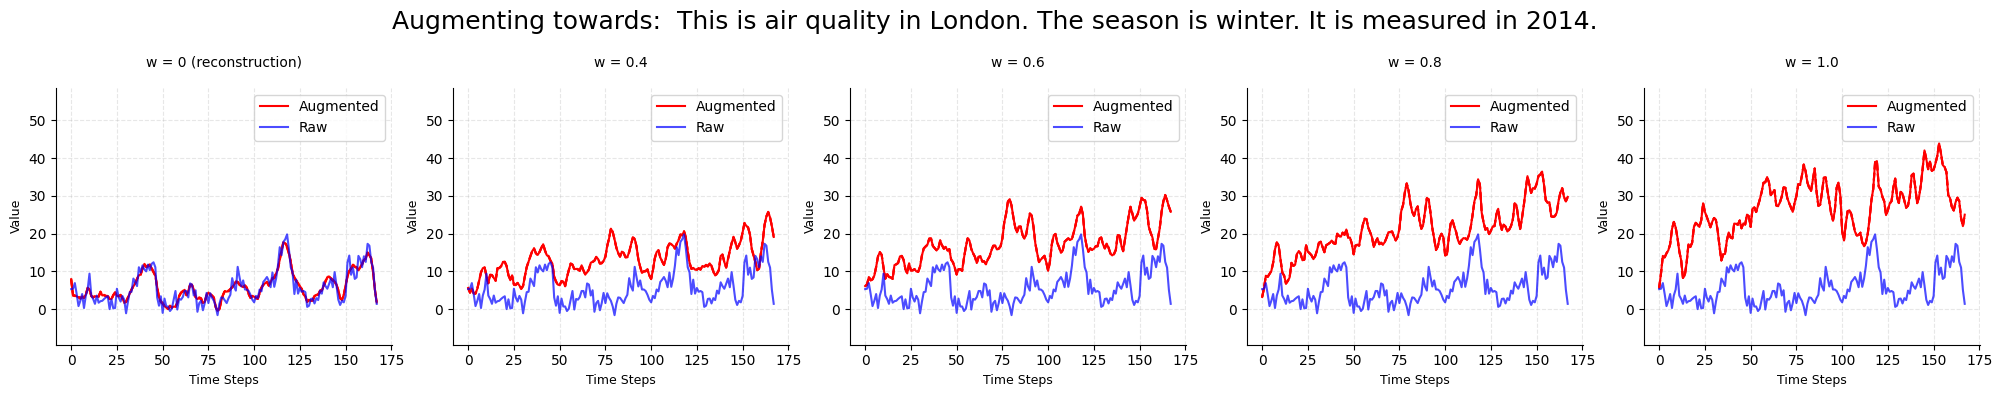

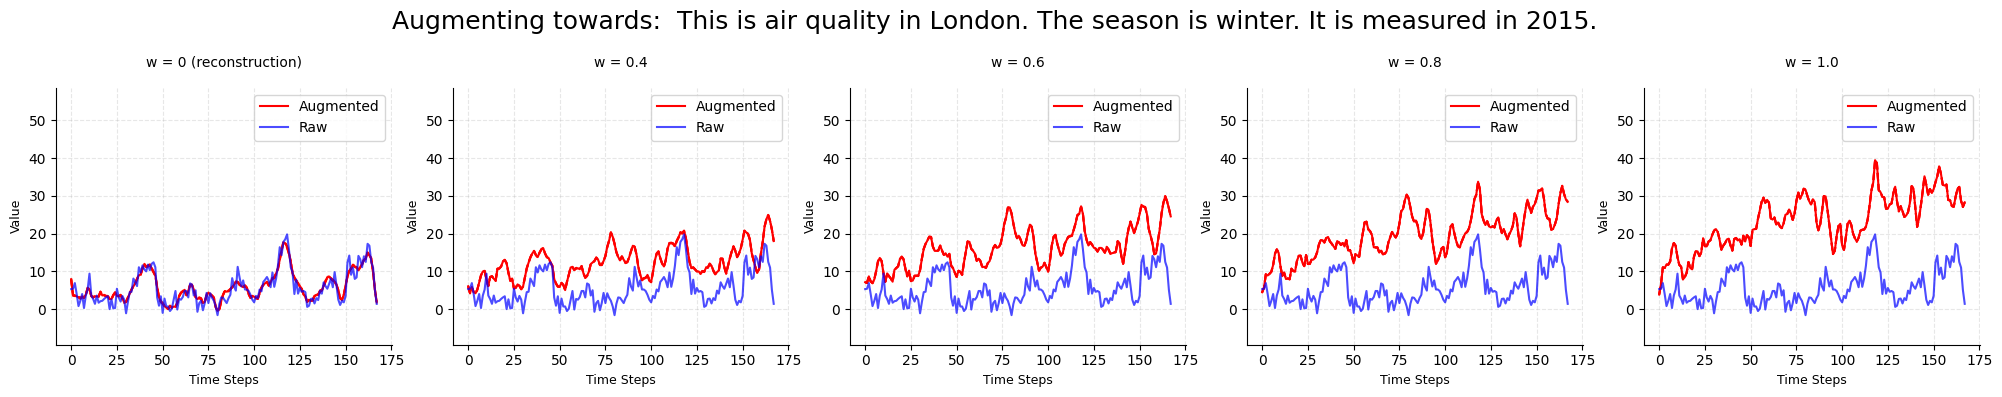

1    It is measured in 2018.
Name: year_str, dtype: object


KeyboardInterrupt: 

In [6]:
tid=1
# viz_generation_marginal(df_train, model, config_dict, tid=tid)
viz_generation_conditional(df_train, model, config_dict, tid=tid, sampling=True, b=100, ep=200)

# Eval

In [9]:
with open('run/prepare_evals/air_quality.py', 'r') as file:
    exec(file.read())
with open('run/eval.py', 'r') as file:
    exec(file.read())

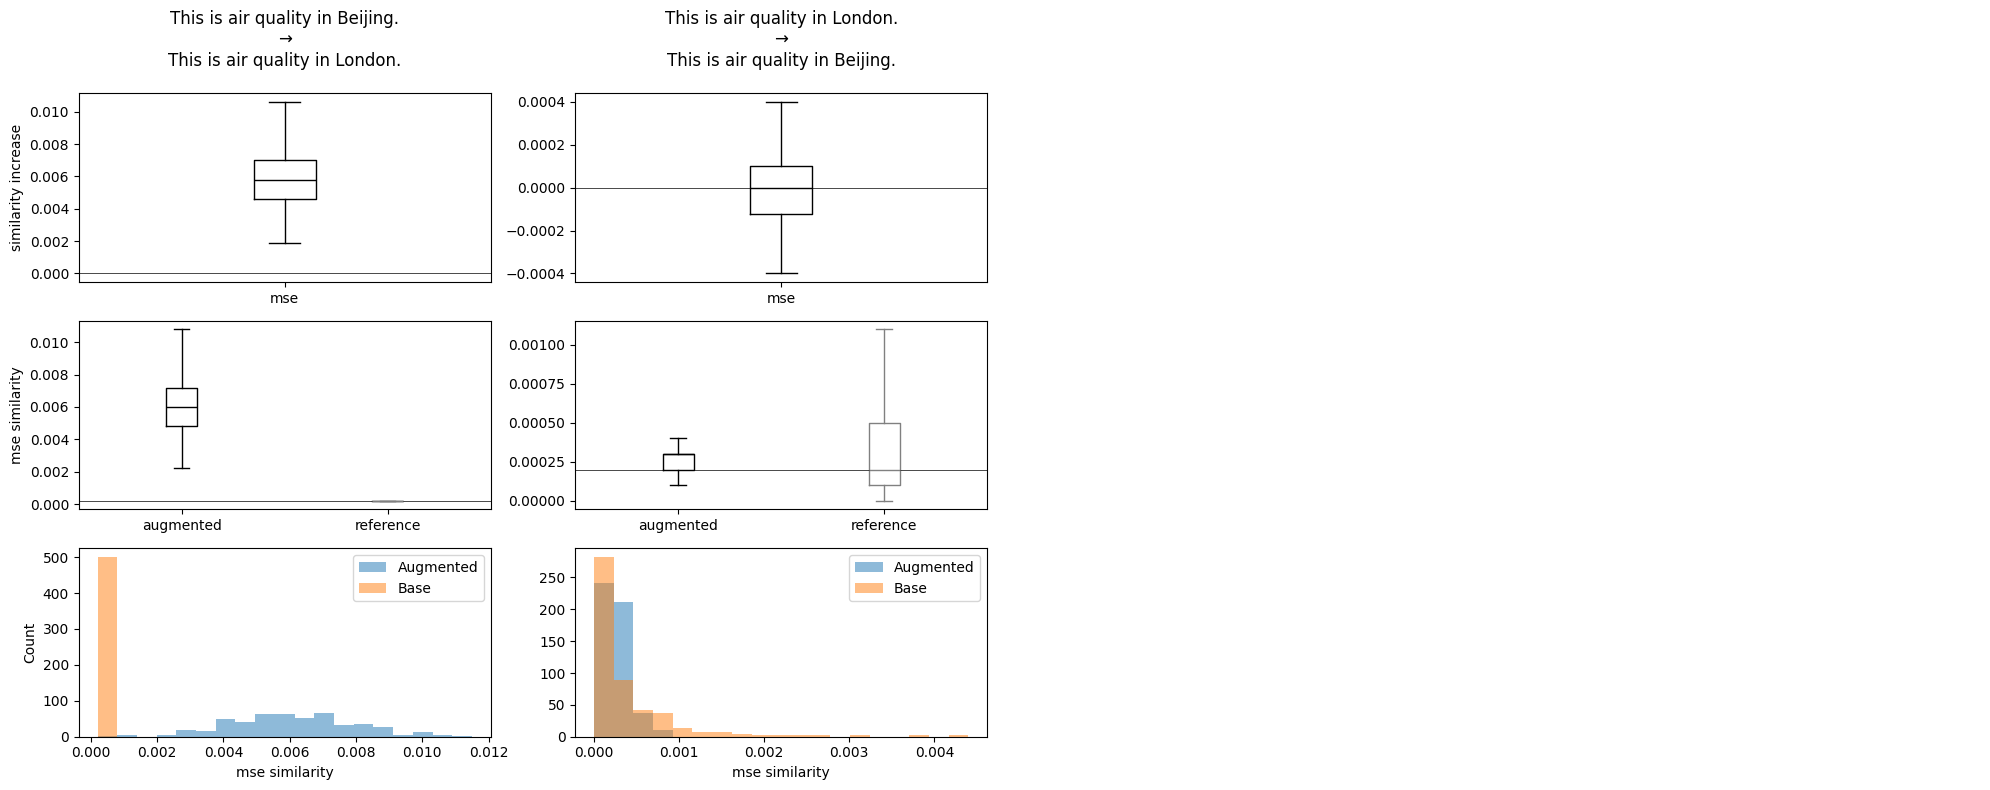

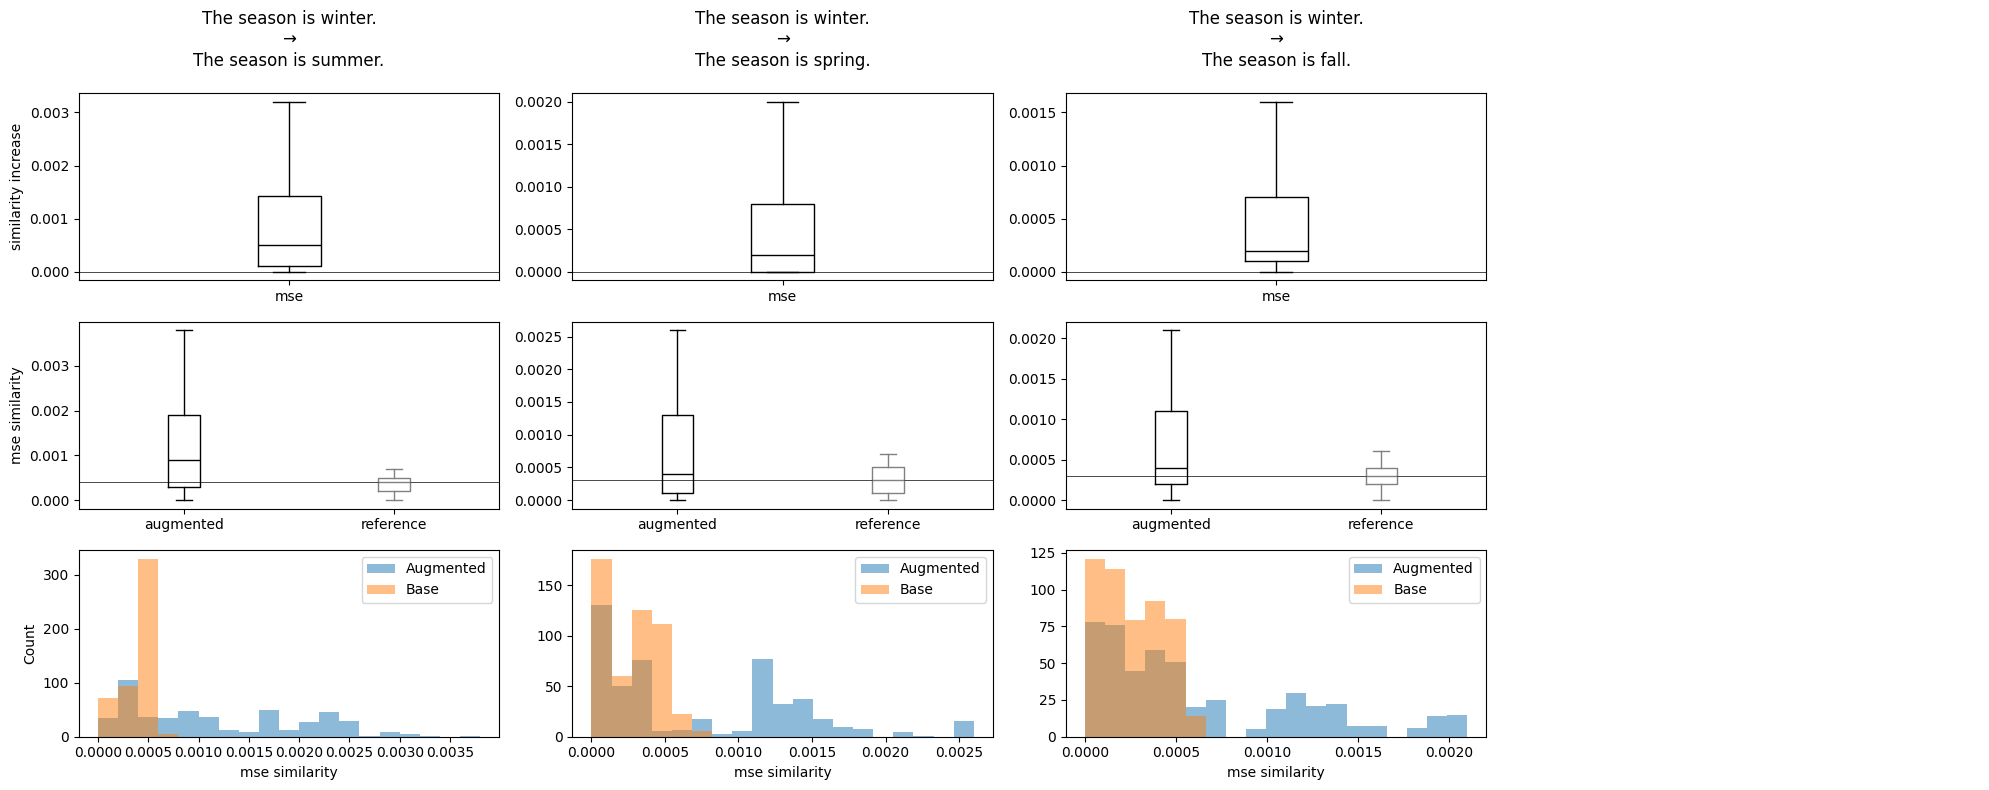

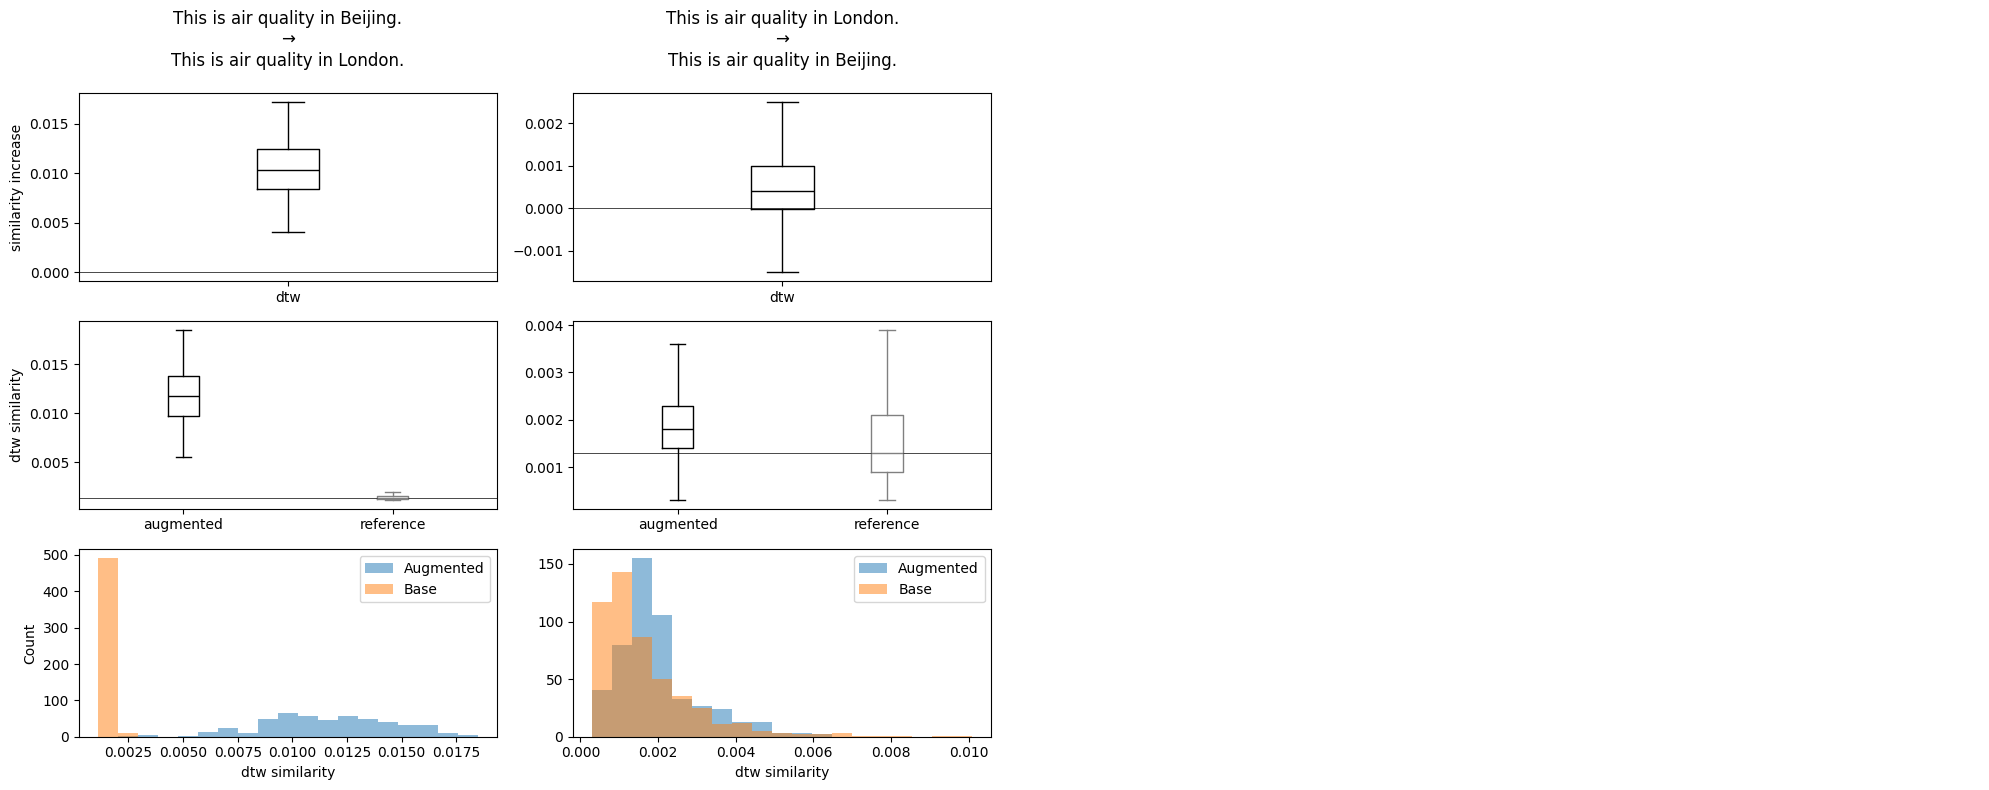

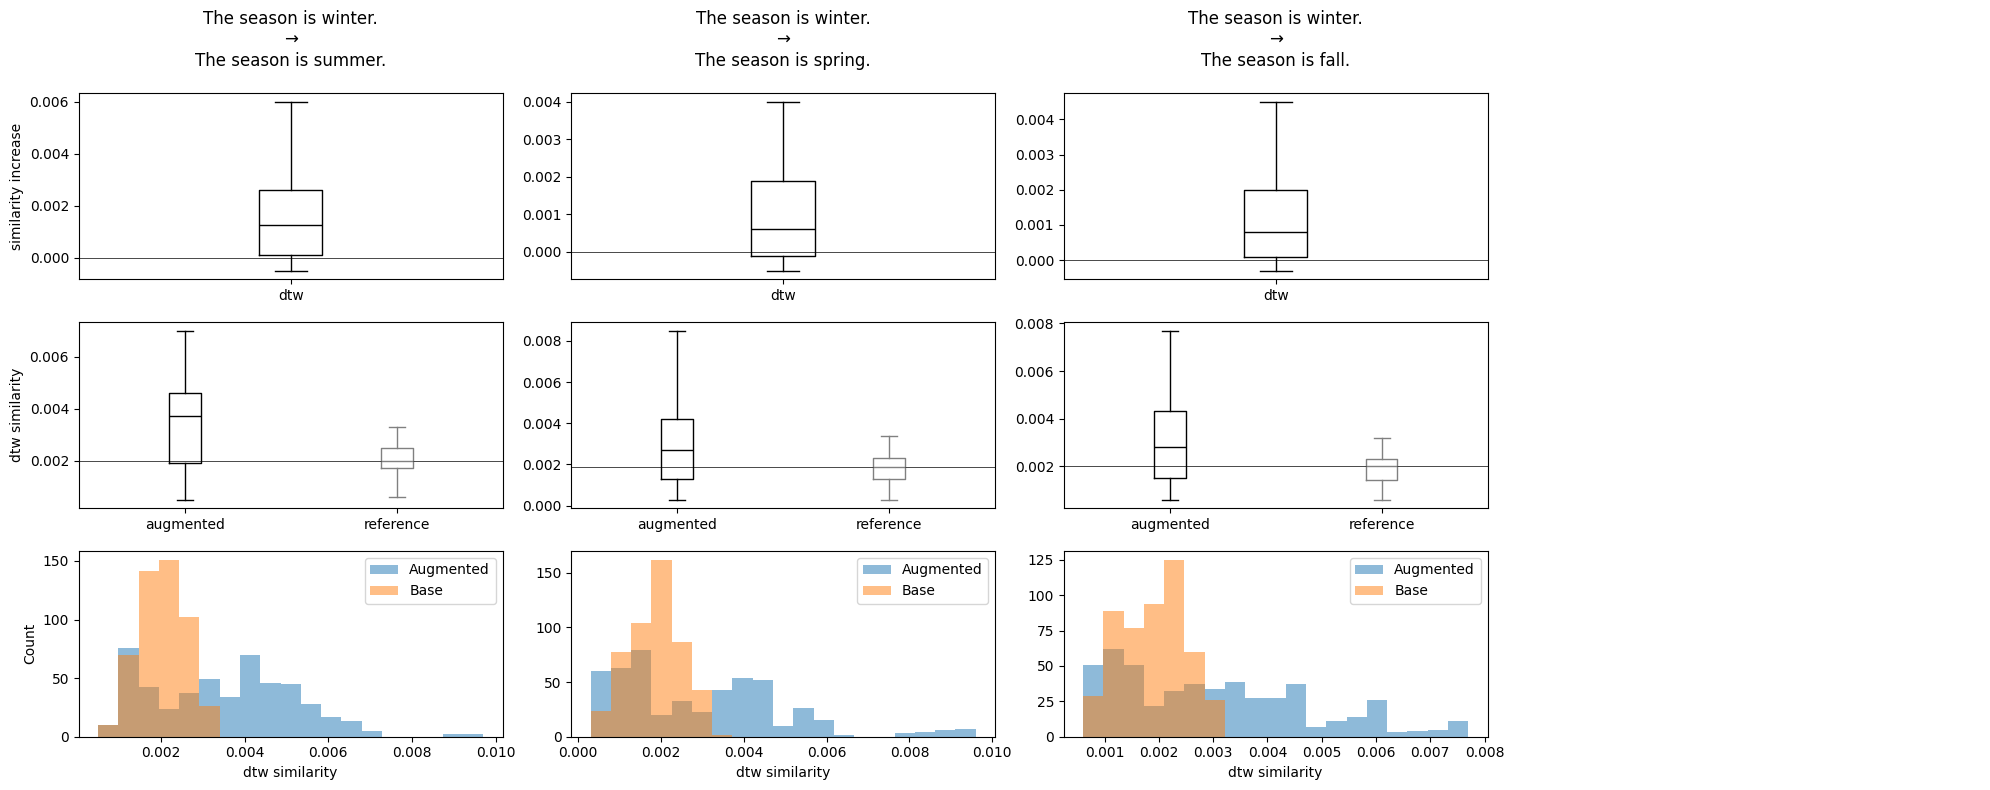

In [10]:
# Define the base augmentation pairs
df_dists = pd.DataFrame()
for df in dist_res_all[0]['dists_dict'].values():
    df_dists = pd.concat([df_dists, df], ignore_index=True)
res_df = eng_dists_multiple(df_dists, base_aug_dict, metric = 'mse')
res_df = eng_dists_multiple(df_dists, base_aug_dict, metric = 'dtw')


city_str (5.1666, 5.3113, 5.3127)
season_str (0.636, 2.7476, 4.3305)


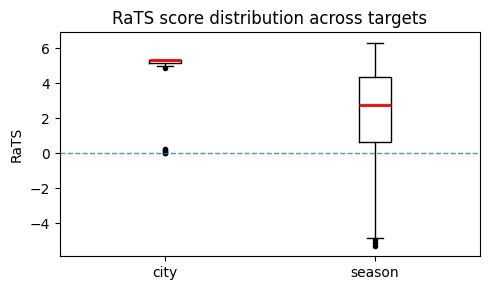

city_str (4.4561, 4.7125, 4.7181)
season_str (0.6536, 1.9942, 2.962)


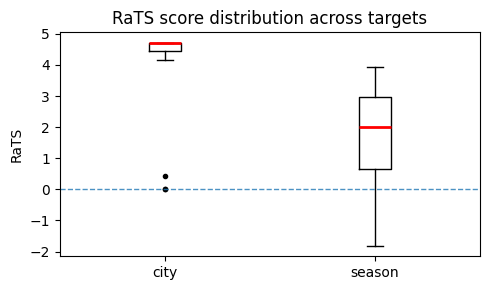

city_str (4.3807, 4.621, 4.6334)
season_str (-0.5787, 0.15, 2.6867)


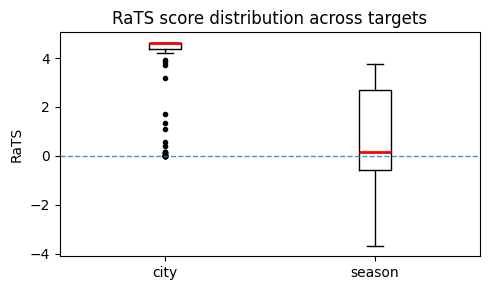

In [11]:
names = {'city_str': 'city', 'season_str': 'season'}
for res_arg in rats_res_all:
    res = res_arg['dists_dict']
    # -- reformat the res to a dataframe ---------------------------
    box_df = pd.DataFrame()
    for y_col in res.keys():
        score_iqr = (res[y_col]['rats_summ']['q25'], res[y_col]['rats_summ']['q50'], res[y_col]['rats_summ']['q75'])
        score_df = pd.DataFrame(res[y_col]['df2pred']['RaTS'].values, columns=[names[y_col]])
        box_df = pd.concat([box_df, score_df], axis=1)
        print(y_col, score_iqr)

    # ── basic box plot ─────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(5,3))
    box_df.plot.box(
        ax=ax,
        patch_artist=False,               # keeps the boxes solid; remove if you prefer hollow
        boxprops=dict(color="black"),    # outline of the box
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="red", linewidth=2),
        flierprops=dict(markeredgecolor="black", markerfacecolor="black", marker="o", markersize=3)
    )
    ax.set_xticklabels(box_df.columns)
    ax.axhline(0, linewidth=1, linestyle="--", alpha=0.8)
    ax.set_title("RaTS score distribution across targets")
    ax.set_ylabel("RaTS")
    plt.tight_layout()
    plt.show()
    